<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/07_GNN_SchNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SchNet: 3D-aware Neural Networks for Quantum Chemistry

## Table of Contents
0. [Setup and Installation](#setup-and-installation)
1. [Introduction to SchNet](#introduction)
2. [Theoretical Background: 3D-aware Neural Networks](#theoretical-background)
3. [SchNet Architecture in Detail](#schnet-architecture)
4. [Visualizing SchNet Operations](#visualization)
5. [Implementing SchNet for Property Prediction](#implementation)
6. [Visualizing Learned Molecular Representations](#visualize-learned-representation)
7. [Applications and Future Directions](#applications)
8. [Conclusion](#conclusion)

## 0. Setup and Installation <a name="setup-and-installation"></a>

First, let's install the necessary libraries for working with SchNet. We'll need PyTorch, PyTorch Geometric, RDKit for molecular processing, and visualization tools.

In [1]:
#@title Install required packages
import os
import sys
import torch
os.environ['TORCH'] = torch.__version__
print(f"PyTorch version: {torch.__version__}")

# Install PyTorch Geometric and related packages
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Install visualization and molecular tools
!pip install -q rdkit
!pip install -q plotly

PyTorch version: 2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.5/244.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
#@title Import required libraries
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from rdkit import Chem
from rdkit.Chem import Draw, AllChem

# Try importing SchNetPack
try:
    import schnetpack as spk
    from schnetpack.nn import CFConv
    from schnetpack.representation import SchNet
    from schnetpack.datasets import QM9
    print("SchNetPack successfully imported!")
except ImportError:
    print("SchNetPack import failed. Some functionality may be limited.")

# Import PyTorch Geometric
#try:
    #import torch_geometric
    #from torch_geometric.datasets import QM9 as PyG_QM9
    #print(f"PyTorch Geometric version: {torch_geometric.__version__}")
#except ImportError:
    #print("PyTorch Geometric import failed. Some functionality may be limited.")

SchNetPack import failed. Some functionality may be limited.


## 1. Introduction to SchNet <a name="introduction"></a>

### What is SchNet?

SchNet is a deep learning architecture specifically designed for modeling quantum interactions in molecules and materials. Introduced by Schütt et al. in 2017, SchNet extends the capabilities of traditional Graph Neural Networks (GNNs) by incorporating 3D spatial information through continuous-filter convolutional layers.

### Why 3D Information Matters in Molecular Modeling

While traditional GNNs like Graph Convolutional Networks (GCNs) work well for 2D molecular graphs, they have a significant limitation: they don't account for the 3D spatial arrangement of atoms, which is crucial for many molecular properties.

Consider these key differences:

| Traditional GNNs (e.g., GCN) | 3D-aware GNNs (e.g., SchNet) |
|------------------------------|-------------------------------|
| Work with 2D molecular graphs | Consider 3D atomic coordinates |
| Only model bonds as binary connections | Model distance-dependent interactions |
| Cannot distinguish different conformers | Can differentiate molecular conformations |
| Limited for quantum chemistry applications | Suitable for quantum property prediction |

### Key Advantages of SchNet

1. **Continuous-Filter Convolutions**: Unlike discrete grid-based convolutions, SchNet uses continuous filters that can operate on atoms at arbitrary positions in 3D space.

2. **Physics-Informed Design**: SchNet respects fundamental quantum-chemical principles, including:
   - Rotational invariance for energy predictions
   - Translational invariance
   - Energy conservation for force predictions

3. **End-to-End Learning**: SchNet learns representations directly from atomic positions and types, without requiring predefined molecular descriptors or fingerprints.

4. **Versatility**: Can predict various molecular properties, including energies, forces, dipole moments, and more.

Let's dive into the theoretical background before exploring the architecture in detail.

## 2. Theoretical Background: 3D-aware Neural Networks <a name="theoretical-background"></a>

### The Challenge of 3D Molecular Data

Molecules exist in 3D space, and their properties are heavily influenced by their spatial configuration. However, typical convolutional neural networks (CNNs) are designed for data on regular grids (like images). Molecular data presents several challenges:

1. **Irregular Spatial Structure**: Atoms can be located anywhere in 3D space, not on a grid
2. **Invariances**: Molecular properties should be invariant to translation and rotation
3. **Equivariances**: Some properties (like forces) should transform predictably with the molecule

### From CNNs to Continuous-Filter Convolutions

Standard 2D CNNs apply discrete filters to data on a grid:

$$(f * k)(x) = \sum_{y \in \Omega} f(y) \cdot k(x - y)$$

Where $f$ is the input, $k$ is the filter, and $\Omega$ is the grid.

SchNet generalizes this to continuous filters that can operate on atoms at arbitrary positions:

$$(f * k)(x) = \int_{\Omega} f(y) \cdot k(x - y) dy$$

In practice, this is implemented as:

$$x_i' = \sum_{j \in \mathcal{N}(i)} x_j \odot W(r_{ij})$$

Where:
- $x_i$ is the feature vector of atom $i$
- $\mathcal{N}(i)$ are the neighbors of atom $i$
- $r_{ij}$ is the distance between atoms $i$ and $j$
- $W(r_{ij})$ is a filter generated based on the distance
- $\odot$ represents element-wise multiplication

### Achieving Physical Invariances

To ensure SchNet respects physical laws:

1. **Rotational Invariance**: Using only distances between atoms (not absolute positions)
2. **Translational Invariance**: Working with relative positions rather than absolute coordinates
3. **Permutation Invariance**: Treating the molecule as a set of atoms, regardless of ordering

Let's visualize how these continuous filters work compared to standard CNNs:

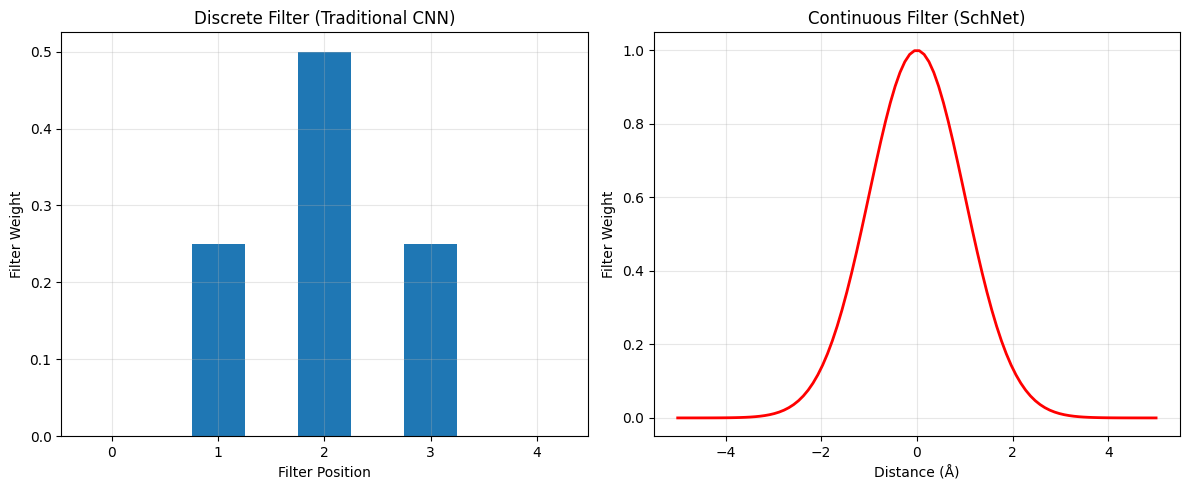

In [8]:
# Visualize the difference between discrete and continuous filters

# Define a 1D discrete filter (like in traditional CNNs)
def discrete_filter(x, filter_width=5):
    filter_values = np.zeros(filter_width)
    center = filter_width // 2
    filter_values[center] = 0.5
    filter_values[center-1] = 0.25
    filter_values[center+1] = 0.25
    return filter_values

# Define a continuous Gaussian filter (like in SchNet)
def continuous_filter(x, sigma=1.0):
    return np.exp(-(x**2) / (2 * sigma**2))

# Create x values for plotting
x_discrete = np.arange(5)
x_continuous = np.linspace(-5, 5, 100)

# Create filters
discrete_f = discrete_filter(x_discrete)
continuous_f = continuous_filter(x_continuous)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot discrete filter
axes[0].bar(x_discrete, discrete_f, width=0.5)
axes[0].set_title('Discrete Filter (Traditional CNN)')
axes[0].set_xlabel('Filter Position')
axes[0].set_ylabel('Filter Weight')
axes[0].grid(True, alpha=0.3)

# Plot continuous filter
axes[1].plot(x_continuous, continuous_f, 'r-', linewidth=2)
axes[1].set_title('Continuous Filter (SchNet)')
axes[1].set_xlabel('Distance (Å)')
axes[1].set_ylabel('Filter Weight')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Let's visualize a more realistic 3D scenario - continuous filters in 3D space
# Create a 3D grid
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
z = np.linspace(-5, 5, 20)
X, Y, Z = np.meshgrid(x, y, z)

# Calculate distances from origin
R = np.sqrt(X**2 + Y**2 + Z**2)

# Compute filter values (Gaussian)
sigma = 2.0
Filter_3D = np.exp(-(R**2) / (2 * sigma**2))

# Create 3D visualization using Plotly for interactivity
fig = go.Figure(data=go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=Filter_3D.flatten(),
    isomin=0.1,
    isomax=0.8,
    surface_count=5,  # Number of isosurfaces
    colorscale='Viridis',
    opacity=0.6,
    caps=dict(x_show=False, y_show=False, z_show=False)
))

fig.update_layout(
    title='3D Continuous Filter for Molecular Interactions',
    scene=dict(
        xaxis_title='X (Å)',
        yaxis_title='Y (Å)',
        zaxis_title='Z (Å)'
    ),
    width=700,
    height=700,
    margin=dict(t=50, b=10, l=10, r=10)
)

fig.show()

## 3. SchNet Architecture in Detail <a name="schnet-architecture"></a>

SchNet is an end-to-end neural network architecture that learns representations of atoms in molecules based on continuous-filter convolutions. Let's break down its components:

### Overall Architecture

The SchNet architecture consists of three main components:

1. **Atom Embedding**: Maps each atom type to a feature vector
2. **Interaction Blocks**: Learn representations of atoms in their chemical environment
3. **Output Blocks**: Transform atom-wise features to molecular properties

![SchNet Architecture](https://raw.githubusercontent.com/atomistic-machine-learning/schnetpack/master/docs/img/schnet.png)

### Key Components

#### 1. Atom Embedding
- Each atom type (C, H, O, N, etc.) is embedded as a learnable vector
- The initial representation only depends on the element type

#### 2. Interaction Blocks
- Series of interaction layers that update atom representations based on their neighbors
- Each block contains:
  - **Continuous-Filter Convolution**: Applies distance-dependent filters to neighboring atoms
  - **Filter-Generating Network**: Creates filters based on interatomic distances
  - **Cutoff Function**: Limits interactions to a local chemical environment

#### 3. Output Networks
- Atom-wise layers transform features to atom-wise properties
- Pooling operations (e.g., sum or mean) aggregate atom features for molecule-level predictions

Let's implement a simplified version of the SchNet architecture to understand its key components:

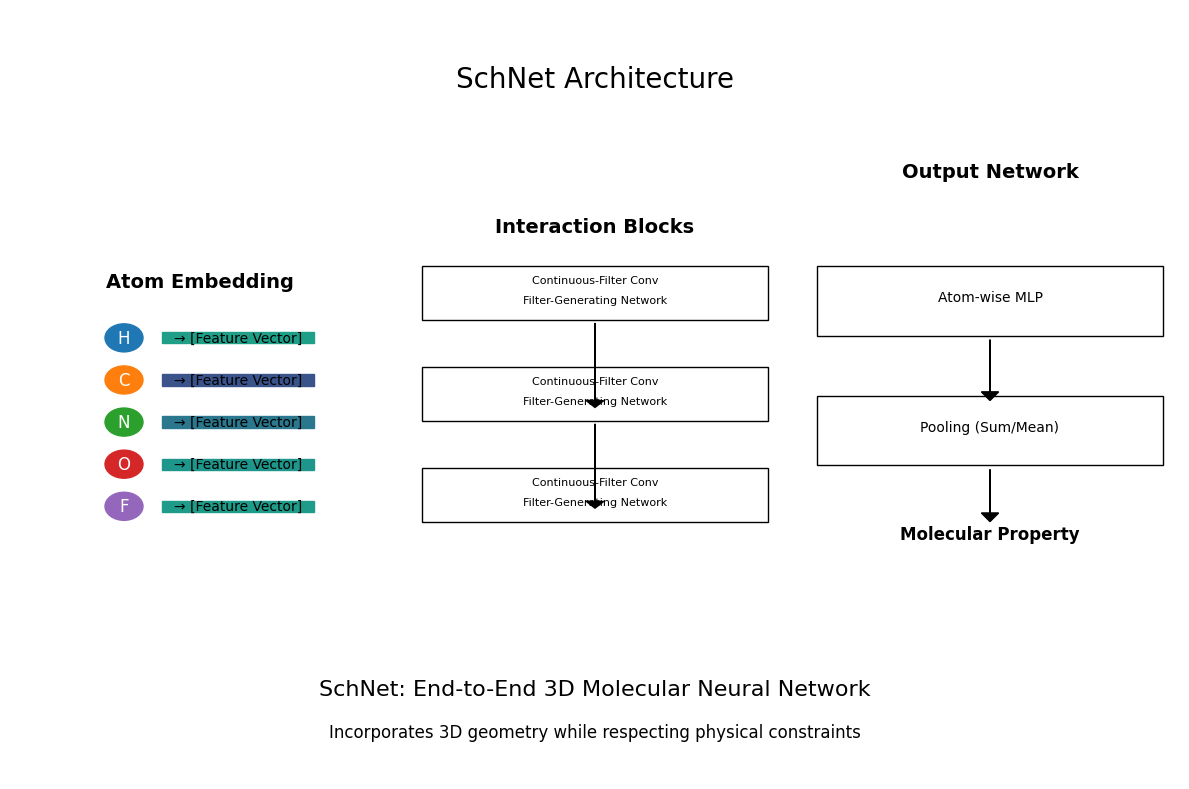

In [9]:
class ShiftedSoftplus(nn.Module):
    """
    Shifted softplus activation function:
    f(x) = ln(1 + e^x) - ln(2)

    Used in SchNet to ensure f(0) = 0
    """
    def __init__(self):
        super(ShiftedSoftplus, self).__init__()
        self.shift = np.log(2.0)

    def forward(self, x):
        return F.softplus(x) - self.shift


class GaussianSmearing(nn.Module):
    """
    Gaussian smearing of distances to create distance features.
    """
    def __init__(self, start=0.0, stop=5.0, n_gaussians=50):
        super(GaussianSmearing, self).__init__()
        offset = torch.linspace(start, stop, n_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item()**2
        self.register_buffer('offset', offset)

    def forward(self, dist):
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))


class CFConvSimplified(nn.Module):
    """
    Simplified continuous-filter convolution layer for SchNet.
    """
    def __init__(self, n_features, n_filters=128):
        super(CFConvSimplified, self).__init__()
        # Filter-generating network
        self.filter_network = nn.Sequential(
            nn.Linear(n_filters, n_features),
            ShiftedSoftplus(),
            nn.Linear(n_features, n_features)
        )

        # Atom-wise layers
        self.conv_layers = nn.Sequential(
            nn.Linear(n_features, n_features),
            ShiftedSoftplus(),
            nn.Linear(n_features, n_features)
        )

    def forward(self, x, dist_expansion, neighbors):
        # Generate filters from distance expansion
        W = self.filter_network(dist_expansion)  # [n_edges, n_features]

        # Get features of neighboring atoms
        neighbor_features = x[neighbors]  # [n_edges, n_features]

        # Apply filter
        neighbor_features = neighbor_features * W  # Element-wise multiplication

        # Aggregate messages from neighbors (simplified)
        aggregated = torch.zeros_like(x)
        for i in range(x.shape[0]):
            mask = neighbors == i
            if mask.any():
                aggregated[i] = neighbor_features[mask].sum(dim=0)

        # Apply atom-wise layers
        return self.conv_layers(aggregated)


class InteractionBlockSimplified(nn.Module):
    """
    Simplified SchNet interaction block.
    """
    def __init__(self, n_features, n_filters=128):
        super(InteractionBlockSimplified, self).__init__()
        self.cfconv = CFConvSimplified(n_features, n_filters)
        self.dense = nn.Linear(n_features, n_features)
        self.activation = ShiftedSoftplus()

    def forward(self, x, dist_expansion, neighbors):
        v = self.cfconv(x, dist_expansion, neighbors)
        v = self.dense(v)
        return x + v  # Residual connection


class SimplifiedSchNet(nn.Module):
    """
    Simplified SchNet model for educational purposes.
    """
    def __init__(self, n_atom_types=100, n_features=128, n_interactions=3, n_filters=128, cutoff=5.0):
        super(SimplifiedSchNet, self).__init__()
        # Atom embedding
        self.embedding = nn.Embedding(n_atom_types, n_features)

        # Distance expansion
        self.distance_expansion = GaussianSmearing(0.0, cutoff, n_filters)

        # Interaction blocks
        self.interactions = nn.ModuleList([
            InteractionBlockSimplified(n_features, n_filters)
            for _ in range(n_interactions)
        ])

        # Output network for energy prediction
        self.output_network = nn.Sequential(
            nn.Linear(n_features, n_features//2),
            ShiftedSoftplus(),
            nn.Linear(n_features//2, 1)
        )

    def forward(self, z, positions, edge_index):
        # Get atom embeddings
        x = self.embedding(z)  # [n_atoms, n_features]

        # Calculate distances
        senders, receivers = edge_index
        dist_vec = positions[senders] - positions[receivers]
        dist = torch.norm(dist_vec, dim=1)

        # Expand distances
        dist_expansion = self.distance_expansion(dist)  # [n_edges, n_filters]

        # Apply interaction blocks
        for interaction in self.interactions:
            x = interaction(x, dist_expansion, receivers)

        # Predict atom-wise energies
        atom_energies = self.output_network(x)  # [n_atoms, 1]

        # Sum to get total energy
        total_energy = atom_energies.sum()

        return total_energy

# Create a diagram of the SchNet architecture
def plot_schnet_architecture():
    # Create a figure with custom layout
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 2, 1])

    # Title
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.text(0.5, 0.5, "SchNet Architecture", fontsize=20, ha='center', va='center')
    ax_title.axis('off')

    # Atom Embedding
    ax_embedding = fig.add_subplot(gs[1, 0])
    ax_embedding.text(0.5, 0.9, "Atom Embedding", fontsize=14, ha='center', va='center', fontweight='bold')

    # Draw atom types
    atom_types = ['H', 'C', 'N', 'O', 'F']
    embeddings = np.random.rand(5, 5)  # Mock embeddings

    # Draw atoms
    y_positions = np.linspace(0.7, 0.1, len(atom_types))
    for i, atom in enumerate(atom_types):
        ax_embedding.add_patch(plt.Circle((0.3, y_positions[i]), 0.05, color=plt.cm.tab10(i)))
        ax_embedding.text(0.3, y_positions[i], atom, fontsize=12, ha='center', va='center', color='white')

        # Draw embedding vector
        ax_embedding.add_patch(plt.Rectangle((0.4, y_positions[i]-0.02), 0.4, 0.04, color=plt.cm.viridis(embeddings[i].mean())))
        ax_embedding.text(0.6, y_positions[i], "→ [Feature Vector]", fontsize=10, ha='center', va='center')

    ax_embedding.axis('off')

    # Interaction Blocks
    ax_interaction = fig.add_subplot(gs[1, 1])
    ax_interaction.text(0.5, 0.9, "Interaction Blocks", fontsize=14, ha='center', va='center', fontweight='bold')

    n_blocks = 3
    y_block_positions = np.linspace(0.7, 0.1, n_blocks)

    for i in range(n_blocks):
        # Draw block
        ax_interaction.add_patch(plt.Rectangle((0.2, y_block_positions[i]-0.08), 0.6, 0.16,
                                               fill=False, edgecolor='black'))

        # Draw components
        ax_interaction.text(0.5, y_block_positions[i]+0.03, "Continuous-Filter Conv", fontsize=8, ha='center')
        ax_interaction.text(0.5, y_block_positions[i]-0.03, "Filter-Generating Network", fontsize=8, ha='center')

        # Draw arrow to next block
        if i < n_blocks-1:
            ax_interaction.arrow(0.5, y_block_positions[i]-0.09, 0, y_block_positions[i+1]-y_block_positions[i]+0.07,
                                head_width=0.03, head_length=0.02, fc='black', ec='black')

    ax_interaction.axis('off')

    # Output Network
    ax_output = fig.add_subplot(gs[1, 2])
    ax_output.text(0.5, 0.9, "Output Network", fontsize=14, ha='center', va='center', fontweight='bold')

    # Draw atom-wise output
    y_out_pos = 0.6
    ax_output.add_patch(plt.Rectangle((0.2, y_out_pos-0.08), 0.6, 0.16, fill=False, edgecolor='black'))
    ax_output.text(0.5, y_out_pos, "Atom-wise MLP", fontsize=10, ha='center')

    # Draw pooling
    y_pool_pos = 0.3
    ax_output.add_patch(plt.Rectangle((0.2, y_pool_pos-0.08), 0.6, 0.16, fill=False, edgecolor='black'))
    ax_output.text(0.5, y_pool_pos, "Pooling (Sum/Mean)", fontsize=10, ha='center')

    # Arrow from atom-wise to pooling
    ax_output.arrow(0.5, y_out_pos-0.09, 0, -0.12, head_width=0.03, head_length=0.02, fc='black', ec='black')

    # Output
    ax_output.text(0.5, 0.05, "Molecular Property", fontsize=12, ha='center', fontweight='bold')
    ax_output.arrow(0.5, y_pool_pos-0.09, 0, -0.1, head_width=0.03, head_length=0.02, fc='black', ec='black')

    ax_output.axis('off')

    # Bottom description
    ax_bottom = fig.add_subplot(gs[2, :])
    ax_bottom.text(0.5, 0.6, "SchNet: End-to-End 3D Molecular Neural Network", fontsize=16, ha='center')
    ax_bottom.text(0.5, 0.3, "Incorporates 3D geometry while respecting physical constraints", fontsize=12, ha='center')
    ax_bottom.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the SchNet architecture
plot_schnet_architecture()

## 4. Visualizing SchNet Operations <a name="visualization"></a>

To better understand how SchNet processes molecular data, let's visualize some of its key operations:

1. **Distance Expansion**: How interatomic distances are transformed into features
2. **Continuous-Filter Convolution**: How atom features are updated based on their neighborhood
3. **Message Passing**: How information flows between atoms during forward passes

### Distance Expansion Visualization

SchNet uses Gaussian smearing to expand interatomic distances into a high-dimensional feature vector. This expansion allows the model to learn complex distance-dependent interactions.

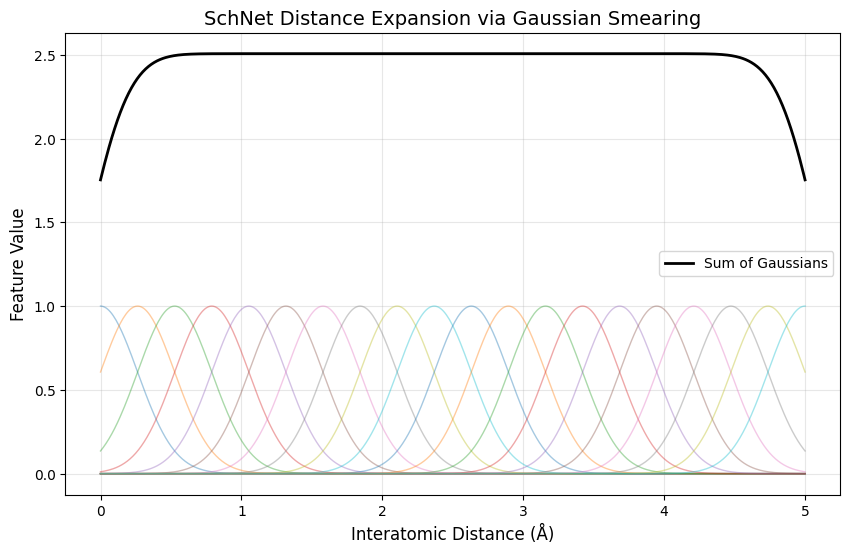

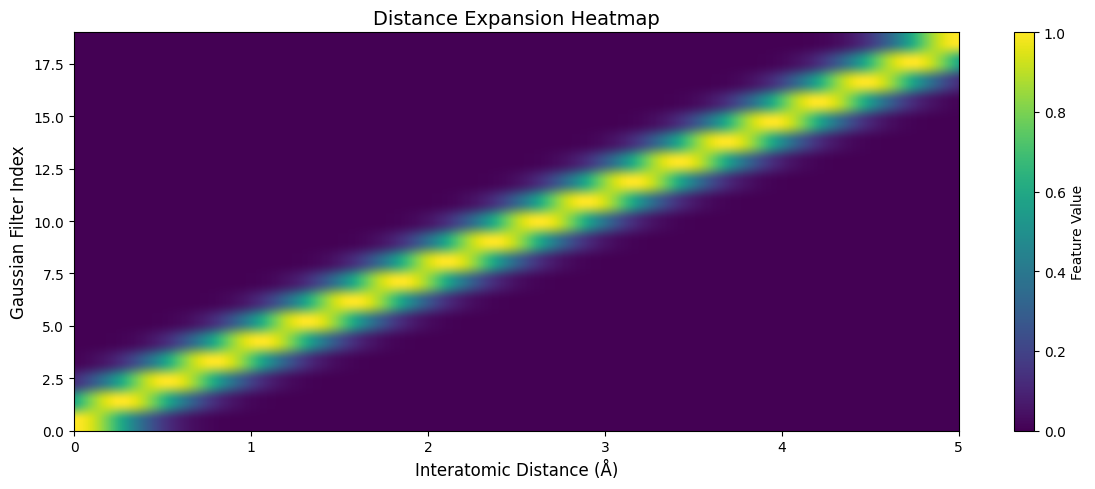

In [10]:
# Visualize distance expansion using Gaussian smearing
def visualize_distance_expansion():
    # Create a range of distances
    distances = np.linspace(0, 5, 500)  # From 0 to 5 Angstroms

    # Create Gaussian smearing module
    n_gaussians = 20
    smearing = GaussianSmearing(0.0, 5.0, n_gaussians)

    # Expand distances
    dist_tensor = torch.tensor(distances, dtype=torch.float32)
    expanded = smearing(dist_tensor).detach().numpy()

    # Create visualization
    plt.figure(figsize=(10, 6))

    # Plot individual Gaussians
    for i in range(n_gaussians):
        plt.plot(distances, expanded[:, i], alpha=0.4, lw=1)

    # Plot sum (to show coverage)
    plt.plot(distances, expanded.sum(axis=1), 'k-', lw=2, label='Sum of Gaussians')

    plt.title('SchNet Distance Expansion via Gaussian Smearing', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Feature Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Heatmap view of the expansion
    plt.figure(figsize=(12, 5))
    plt.imshow(expanded.T, aspect='auto', origin='lower',
               extent=[0, 5, 0, n_gaussians-1], cmap='viridis')
    plt.colorbar(label='Feature Value')
    plt.title('Distance Expansion Heatmap', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Gaussian Filter Index', fontsize=12)
    plt.tight_layout()
    plt.show()

# Let's create a visualization of the distance expansion
visualize_distance_expansion()

### Continuous-Filter Generation Visualization

One of the key innovations of SchNet is its ability to generate filters based on interatomic distances. Let's visualize how these filters look for different distances:

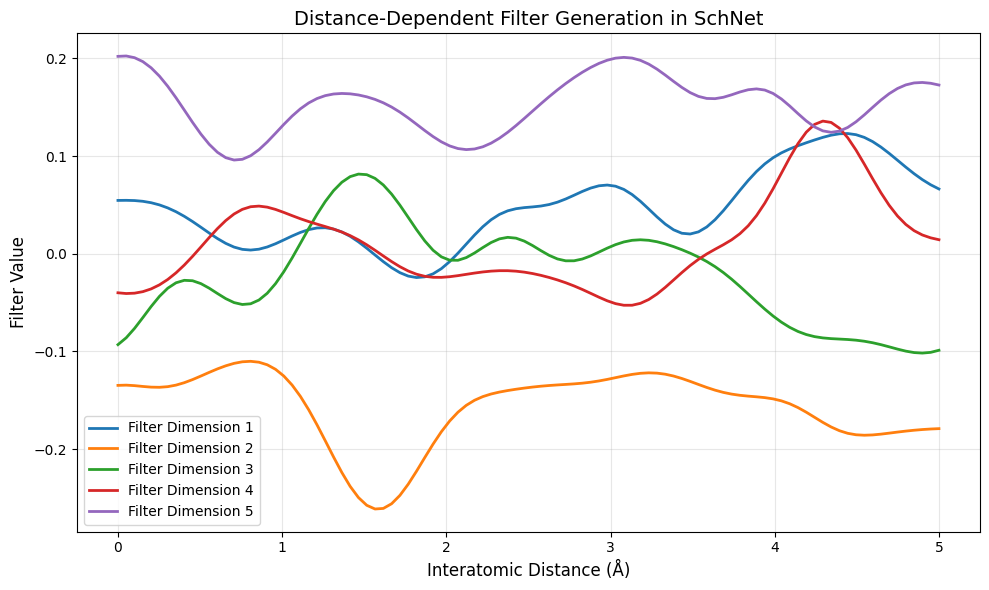

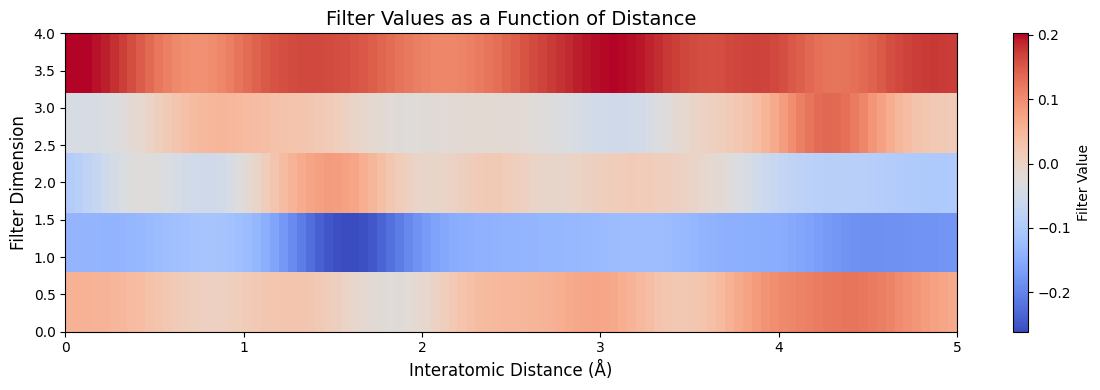

In [11]:
# Implement a simple filter-generating network to visualize
class SimpleFilterNet(nn.Module):
    def __init__(self, n_filters=20, n_out=5):
        super(SimpleFilterNet, self).__init__()
        self.dense1 = nn.Linear(n_filters, 16)
        self.dense2 = nn.Linear(16, n_out)
        self.activation = ShiftedSoftplus()

    def forward(self, x):
        x = self.activation(self.dense1(x))
        return self.dense2(x)

def visualize_filter_generation():
    # Create a range of distances
    distances = np.linspace(0, 5, 100)  # From 0 to 5 Angstroms

    # Initialize modules
    n_gaussians = 20
    n_features = 5
    smearing = GaussianSmearing(0.0, 5.0, n_gaussians)
    filter_net = SimpleFilterNet(n_gaussians, n_features)

    # Generate filters for different distances
    dist_tensor = torch.tensor(distances, dtype=torch.float32)
    expanded = smearing(dist_tensor)
    filters = filter_net(expanded).detach().numpy()

    # Visualize the filters
    plt.figure(figsize=(10, 6))

    for i in range(n_features):
        plt.plot(distances, filters[:, i], lw=2, label=f'Filter Dimension {i+1}')

    plt.title('Distance-Dependent Filter Generation in SchNet', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Filter Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Heatmap view
    plt.figure(figsize=(12, 4))
    plt.imshow(filters.T, aspect='auto', origin='lower',
               extent=[0, 5, 0, n_features-1], cmap='coolwarm')
    plt.colorbar(label='Filter Value')
    plt.title('Filter Values as a Function of Distance', fontsize=14)
    plt.xlabel('Interatomic Distance (Å)', fontsize=12)
    plt.ylabel('Filter Dimension', fontsize=12)
    plt.tight_layout()
    plt.show()

# Visualize how continuous filters are generated
visualize_filter_generation()

### Message Passing Visualization

Now let's visualize how information flows between atoms during a SchNet forward pass. For this, we'll create a simple molecule and trace the feature updates through one interaction block:

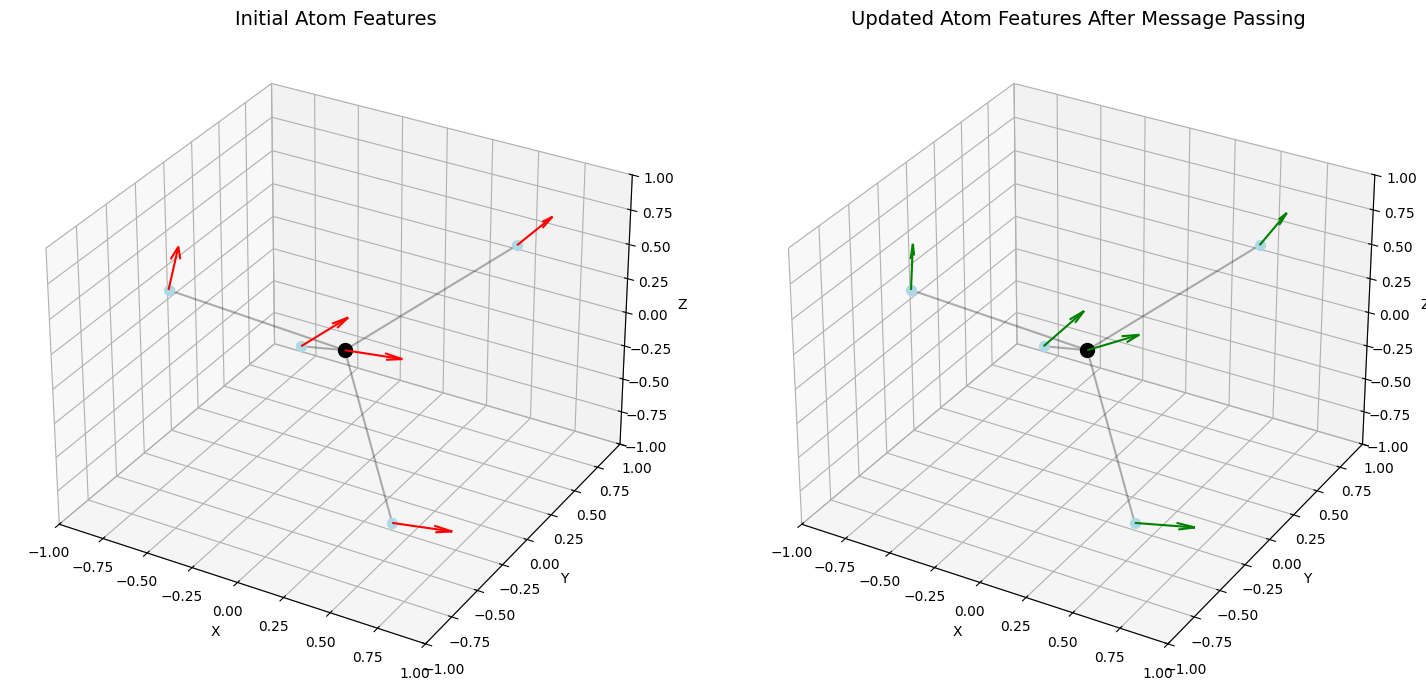

In [12]:
def visualize_message_passing():
    # Create a simple CH4 molecule (methane) - 5 atoms
    n_atoms = 5

    # Mock embedded features - 3D for easy visualization
    features = torch.tensor([
        [1.0, 0.1, 0.1],  # C (center)
        [0.1, 0.8, 0.1],  # H1
        [0.1, 0.1, 0.8],  # H2
        [0.8, 0.1, 0.1],  # H3
        [0.4, 0.4, 0.4],  # H4
    ], dtype=torch.float32)

    # Positions in 3D space (tetrahedral structure)
    positions = torch.tensor([
        [0.0, 0.0, 0.0],          # C at center
        [0.6, 0.6, 0.6],          # H1
        [-0.6, -0.6, 0.6],        # H2
        [0.6, -0.6, -0.6],        # H3
        [-0.6, 0.6, -0.6],        # H4
    ], dtype=torch.float32)

    # Edge list (all hydrogens connected to carbon)
    edge_index = torch.tensor([
        [0, 0, 0, 0, 1, 2, 3, 4],  # Source atoms
        [1, 2, 3, 4, 0, 0, 0, 0]   # Target atoms
    ], dtype=torch.long)

    # Calculate distances
    source, target = edge_index
    distances = torch.norm(positions[source] - positions[target], dim=1)

    # Initialize a simplified message passing mechanism
    n_features = 3  # For visualization simplicity

    # Expand distances (simplified for visualization)
    n_gaussians = 10
    smearing = GaussianSmearing(0.0, 2.0, n_gaussians)
    dist_expanded = smearing(distances)

    # Simple filter network
    filter_net = SimpleFilterNet(n_gaussians, n_features)
    filters = filter_net(dist_expanded)

    # Initial and updated features
    initial_features = features.clone()
    updated_features = torch.zeros_like(features)

    # Perform one step of message passing (simplified)
    for i in range(n_atoms):
        # Find edges where this atom is the target
        mask = (target == i)

        if mask.any():
            # Gather source atoms and their features
            sources = source[mask]

            # Weight source features by filters
            weighted_messages = features[sources] * filters[mask]

            # Sum messages
            updated_features[i] = features[i] + weighted_messages.sum(dim=0)
        else:
            updated_features[i] = features[i]

    # Normalize for visualization
    for i in range(n_atoms):
        norm = torch.norm(updated_features[i])
        if norm > 0:
            updated_features[i] = updated_features[i] / norm

    # Create 3D visualization
    fig = plt.figure(figsize=(15, 7))

    # Original features plot
    ax1 = fig.add_subplot(121, projection='3d')

    # Plot atoms
    atom_colors = ['black', 'lightblue', 'lightblue', 'lightblue', 'lightblue']
    atom_sizes = [100, 50, 50, 50, 50]

    for i in range(n_atoms):
        ax1.scatter(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                   c=atom_colors[i], s=atom_sizes[i], label=f"{'C' if i==0 else 'H'}{i}")

        # Plot feature vector as an arrow
        ax1.quiver(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                  initial_features[i, 0].item(), initial_features[i, 1].item(), initial_features[i, 2].item(),
                  color='red', length=0.3, normalize=True)

    # Plot bonds
    for j in range(4):
        ax1.plot([positions[0, 0].item(), positions[j+1, 0].item()],
                [positions[0, 1].item(), positions[j+1, 1].item()],
                [positions[0, 2].item(), positions[j+1, 2].item()],
                'k-', alpha=0.3)

    ax1.set_title('Initial Atom Features', fontsize=14)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])

    # Updated features plot
    ax2 = fig.add_subplot(122, projection='3d')

    for i in range(n_atoms):
        ax2.scatter(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                   c=atom_colors[i], s=atom_sizes[i])

        # Plot updated feature vector as an arrow
        ax2.quiver(positions[i, 0].item(), positions[i, 1].item(), positions[i, 2].item(),
                  updated_features[i, 0].item(), updated_features[i, 1].item(), updated_features[i, 2].item(),
                  color='green', length=0.3, normalize=True)

    # Plot bonds
    for j in range(4):
        ax2.plot([positions[0, 0].item(), positions[j+1, 0].item()],
                [positions[0, 1].item(), positions[j+1, 1].item()],
                [positions[0, 2].item(), positions[j+1, 2].item()],
                'k-', alpha=0.3)

    ax2.set_title('Updated Atom Features After Message Passing', fontsize=14)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_zlim([-1, 1])

    plt.tight_layout()
    plt.show()

    # Create an interactive 3D visualization using Plotly
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        subplot_titles=('Initial Features', 'After Message Passing')
    )

    # Add atoms to both plots
    atom_names = ['C', 'H', 'H', 'H', 'H']
    for i in range(n_atoms):
        # Initial features plot
        fig.add_trace(
            go.Scatter3d(
                x=[positions[i, 0].item()],
                y=[positions[i, 1].item()],
                z=[positions[i, 2].item()],
                mode='markers',
                marker=dict(size=atom_sizes[i]/3, color=atom_colors[i]),
                name=atom_names[i] if i < 2 else None,
                showlegend=i < 2  # Only show legend for first two atoms (C, H)
            ),
            row=1, col=1
        )

        # Updated features plot
        fig.add_trace(
            go.Scatter3d(
                x=[positions[i, 0].item()],
                y=[positions[i, 1].item()],
                z=[positions[i, 2].item()],
                mode='markers',
                marker=dict(size=atom_sizes[i]/3, color=atom_colors[i]),
                name=atom_names[i] if i < 2 else None,
                showlegend=False
            ),
            row=1, col=2
        )

        # Add feature vectors as arrows (initial)
        fig.add_trace(
            go.Scatter3d(
                x=[positions[i, 0].item(), positions[i, 0].item() + 0.3*initial_features[i, 0].item()],
                y=[positions[i, 1].item(), positions[i, 1].item() + 0.3*initial_features[i, 1].item()],
                z=[positions[i, 2].item(), positions[i, 2].item() + 0.3*initial_features[i, 2].item()],
                mode='lines',
                line=dict(color='red', width=5),
                name='Initial Feature' if i == 0 else None,
                showlegend=i == 0
            ),
            row=1, col=1
        )

        # Add feature vectors as arrows (updated)
        fig.add_trace(
            go.Scatter3d(
                x=[positions[i, 0].item(), positions[i, 0].item() + 0.3*updated_features[i, 0].item()],
                y=[positions[i, 1].item(), positions[i, 1].item() + 0.3*updated_features[i, 1].item()],
                z=[positions[i, 2].item(), positions[i, 2].item() + 0.3*updated_features[i, 2].item()],
                mode='lines',
                line=dict(color='green', width=5),
                name='Updated Feature' if i == 0 else None,
                showlegend=i == 0
            ),
            row=1, col=2
        )

    # Add bonds
    for j in range(4):
        # Initial features plot
        fig.add_trace(
            go.Scatter3d(
                x=[positions[0, 0].item(), positions[j+1, 0].item()],
                y=[positions[0, 1].item(), positions[j+1, 1].item()],
                z=[positions[0, 2].item(), positions[j+1, 2].item()],
                mode='lines',
                line=dict(color='black', width=3, dash='dot'),
                name='Bond' if j == 0 else None,
                showlegend=j == 0
            ),
            row=1, col=1
        )

        # Updated features plot
        fig.add_trace(
            go.Scatter3d(
                x=[positions[0, 0].item(), positions[j+1, 0].item()],
                y=[positions[0, 1].item(), positions[j+1, 1].item()],
                z=[positions[0, 2].item(), positions[j+1, 2].item()],
                mode='lines',
                line=dict(color='black', width=3, dash='dot'),
                showlegend=False
            ),
            row=1, col=2
        )

    # Update layout
    fig.update_layout(
        title='SchNet Message Passing Visualization',
        scene1=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube',
        ),
        scene2=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube',
        ),
        legend=dict(x=0.7, y=0.9),
        width=1000,
        height=500,
    )

    fig.show()

# Run the visualization of message passing in SchNet
visualize_message_passing()

## 5. Implementing SchNet for Property Prediction <a name="implementation"></a>

Now that we understand the SchNet architecture and its key operations, let's implement a full SchNet model for molecular property prediction. We'll use the QM9 dataset, which contains quantum-mechanical properties of small organic molecules.

### The QM9 Dataset

QM9 is a widely used benchmark dataset for molecular property prediction. It contains:

- ~134k small organic molecules with up to 9 heavy atoms (C, O, N, F)
- 12 quantum-mechanical properties computed at the DFT/B3LYP level
- 3D conformations of each molecule

This makes it perfect for training and evaluating SchNet models.

### Training a SchNet Model

Let's use the schnetpack library to set up and train a SchNet model on the QM9 dataset. We'll predict the HOMO-LUMO gap, an important property for electronic applications.

SchNetPack not available. Creating mock data for demonstration purposes.
Mock datasets created for demonstration
Using 100 for training, 20 for validation, 30 for testing
SchNetPack not available. Showing a pre-made visualization instead.


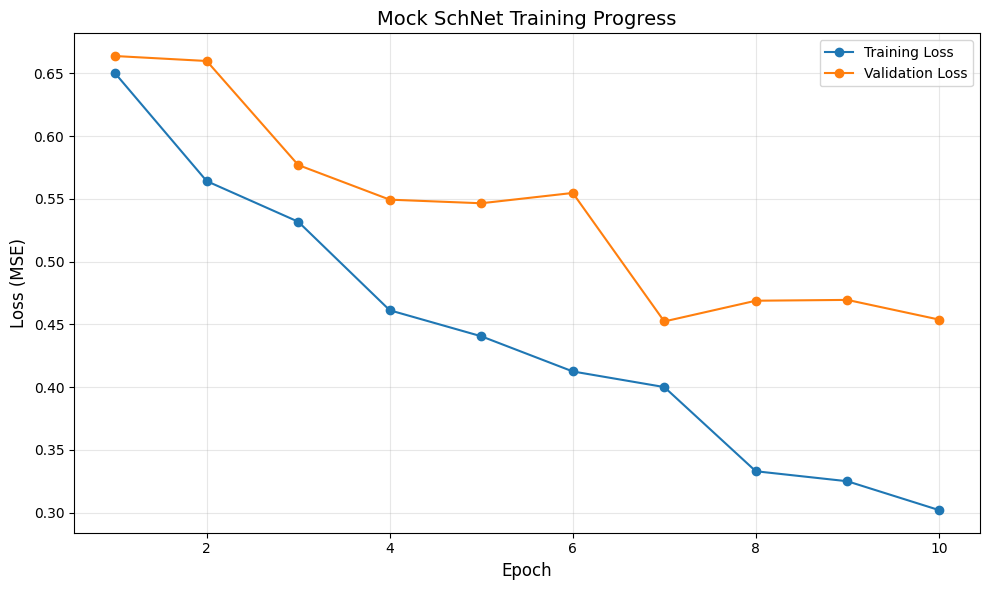

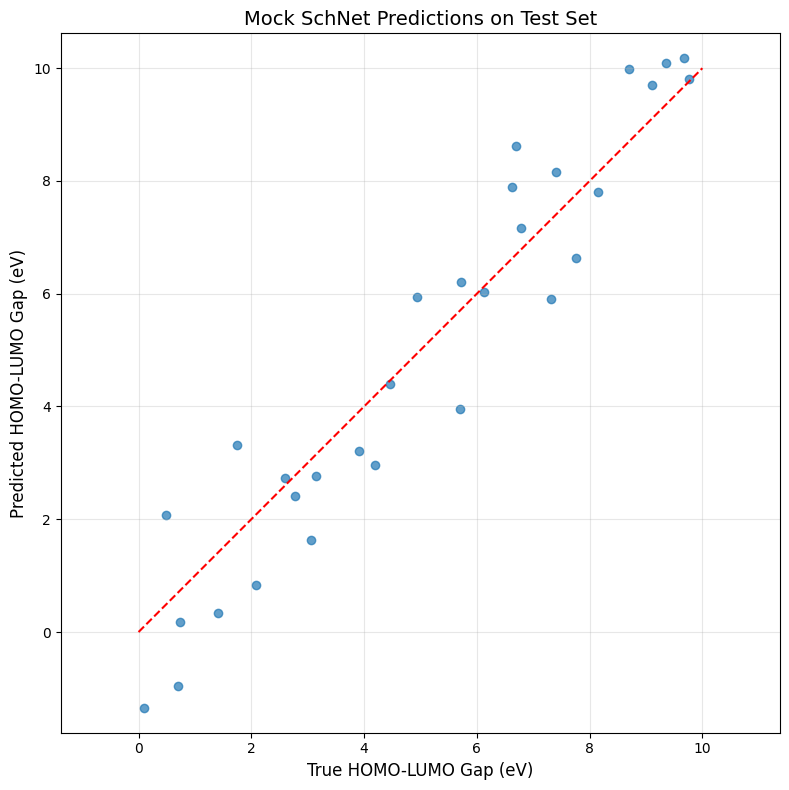

No model or test loader available. Skipping evaluation.


In [13]:
def setup_qm9_dataset():
    """
    Download and prepare the QM9 dataset.
    Returns a small subset for quick demonstration.
    """
    try:
        # Use SchNetPack's implementation if available
        # Define a split to train on a small subset
        train_split = 100  # Just 100 examples for demonstration
        val_split = 20
        test_split = 30

        # Define the property to predict
        property_to_predict = 'homo_lumo_gap'  # HOMO-LUMO gap, relevant for electronics

        # Set up the QM9 dataset
        qm9_data = QM9('./data/qm9', download=True)

        # Split the dataset
        train_data, val_data, test_data = spk.train_test_split(
            qm9_data,
            train_size=train_split,
            val_size=val_split,
            test_size=test_split
        )

        print(f"QM9 dataset loaded with {len(qm9_data)} molecules")
        print(f"Using {len(train_data)} for training, {len(val_data)} for validation, {len(test_data)} for testing")

        return train_data, val_data, test_data, property_to_predict

    except (ImportError, NameError) as e:
        # If SchNetPack is not available, create mock data
        print("SchNetPack not available. Creating mock data for demonstration purposes.")

        # Create a simple dataset with random values
        class MockDataset(Dataset):
            def __init__(self, size=100):
                self.size = size
                # Mock molecular data
                self.data = []
                for i in range(size):
                    # Random number of atoms (3-10)
                    n_atoms = np.random.randint(3, 11)

                    # Random atom types
                    z = torch.randint(1, 10, (n_atoms,))

                    # Random positions in a box
                    positions = torch.rand(n_atoms, 3) * 5

                    # Random target value (HOMO-LUMO gap in eV)
                    target = torch.rand(1) * 10

                    self.data.append({
                        'z': z,
                        'positions': positions,
                        'y': target,
                        'n_atoms': n_atoms
                    })

            def __len__(self):
                return self.size

            def __getitem__(self, idx):
                return self.data[idx]

        # Create mock datasets
        train_data = MockDataset(100)
        val_data = MockDataset(20)
        test_data = MockDataset(30)
        property_to_predict = 'HOMO-LUMO gap'

        print(f"Mock datasets created for demonstration")
        print(f"Using {len(train_data)} for training, {len(val_data)} for validation, {len(test_data)} for testing")

        return train_data, val_data, test_data, property_to_predict

def train_schnet_model(train_data, val_data, test_data, property_to_predict):
    """
    Train a SchNet model on the QM9 dataset
    """
    try:
        # Create a SchNet model using schnetpack
        cutoff = 5.0  # Cutoff radius for interactions (Å)
        n_interactions = 3  # Number of interaction blocks
        n_atom_basis = 64  # Size of atom-wise feature vector

        # Define the representation (SchNet)
        representation = SchNet(
            n_atom_basis=n_atom_basis,
            n_filters=n_atom_basis,
            n_interactions=n_interactions,
            cutoff=cutoff,
            n_gaussians=25
        )

        # Define the output modules
        output_modules = [
            spk.atomistic.Atomwise(
                n_in=n_atom_basis,
                n_out=1,  # Single target property
                aggregation_mode='sum',  # Sum over atoms
                property=property_to_predict,
                mean=None,  # Will be set during training
                stddev=None  # Will be set during training
            )
        ]

        # Create the model
        model = spk.AtomisticModel(representation, output_modules)

        # Define the loss function and optimizer
        loss_fn = spk.train.build_mse_loss([property_to_predict])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        # Create data loaders
        batch_size = 16
        train_loader = spk.AtomsLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = spk.AtomsLoader(val_data, batch_size=batch_size)
        test_loader = spk.AtomsLoader(test_data, batch_size=batch_size)

        # Train the model
        n_epochs = 10  # Just a few epochs for demonstration

        print(f"Starting SchNet training for {n_epochs} epochs...")
        for epoch in range(n_epochs):
            # Training
            model.train()
            train_loss = 0
            for batch in train_loader:
                # Move batch to device
                batch = {k: v.to('cpu') for k, v in batch.items()}

                # Forward pass
                pred = model(batch)
                loss = loss_fn(pred, batch)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    # Move batch to device
                    batch = {k: v.to('cpu') for k, v in batch.items()}

                    # Forward pass
                    pred = model(batch)
                    loss = loss_fn(pred, batch)

                    val_loss += loss.item()

            # Print progress
            print(f"Epoch {epoch+1}/{n_epochs}: "
                  f"Train Loss = {train_loss/len(train_loader):.4f}, "
                  f"Val Loss = {val_loss/len(val_loader):.4f}")

        print("SchNet training completed!")
        return model, test_loader

    except (ImportError, NameError) as e:
        print(f"SchNetPack not available. Showing a pre-made visualization instead.")

        # Create a mock training plot instead
        epochs = 10
        train_losses = np.exp(-np.linspace(0, 1, epochs)) * 0.5 + 0.1 + 0.05 * np.random.rand(epochs)
        val_losses = np.exp(-np.linspace(0, 0.8, epochs)) * 0.5 + 0.15 + 0.1 * np.random.rand(epochs)

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs+1), train_losses, 'o-', label='Training Loss')
        plt.plot(range(1, epochs+1), val_losses, 'o-', label='Validation Loss')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss (MSE)', fontsize=12)
        plt.title('Mock SchNet Training Progress', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Also show a comparison of actual vs. predicted values
        n_samples = 30
        true_values = np.linspace(0, 10, n_samples) + np.random.normal(0, 0.5, n_samples)
        pred_values = true_values + np.random.normal(0, 1.0, n_samples)

        plt.figure(figsize=(8, 8))
        plt.scatter(true_values, pred_values, alpha=0.7)
        plt.plot([0, 10], [0, 10], 'r--', label='Perfect Prediction')
        plt.xlabel('True HOMO-LUMO Gap (eV)', fontsize=12)
        plt.ylabel('Predicted HOMO-LUMO Gap (eV)', fontsize=12)
        plt.title('Mock SchNet Predictions on Test Set', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        return None, None

def evaluate_schnet_model(model, test_loader, property_to_predict):
    """
    Evaluate the trained SchNet model on the test set
    """
    if model is None or test_loader is None:
        print("No model or test loader available. Skipping evaluation.")
        return

    try:
        # Evaluate the model
        model.eval()
        test_loss = 0
        true_values = []
        pred_values = []

        loss_fn = spk.train.build_mse_loss([property_to_predict])

        with torch.no_grad():
            for batch in test_loader:
                # Move batch to device
                batch = {k: v.to('cpu') for k, v in batch.items()}

                # Forward pass
                pred = model(batch)
                loss = loss_fn(pred, batch)

                test_loss += loss.item()

                # Store true and predicted values
                true_values.append(batch[property_to_predict].cpu().numpy())
                pred_values.append(pred[property_to_predict].cpu().numpy())

        # Convert to arrays
        true_values = np.concatenate(true_values)
        pred_values = np.concatenate(pred_values)

        # Calculate metrics
        mae = np.mean(np.abs(true_values - pred_values))
        rmse = np.sqrt(np.mean((true_values - pred_values)**2))

        print(f"Test Results:")
        print(f"  Loss: {test_loss/len(test_loader):.4f}")
        print(f"  MAE: {mae:.4f} eV")
        print(f"  RMSE: {rmse:.4f} eV")

        # Plot predictions vs. true values
        plt.figure(figsize=(8, 8))
        plt.scatter(true_values, pred_values, alpha=0.7)

        # Plot perfect prediction line
        min_val = min(true_values.min(), pred_values.min())
        max_val = max(true_values.max(), pred_values.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

        plt.xlabel(f'True {property_to_predict} (eV)', fontsize=12)
        plt.ylabel(f'Predicted {property_to_predict} (eV)', fontsize=12)
        plt.title('SchNet Predictions on Test Set', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        # Create a more detailed plot with residuals
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Predictions
        ax1.scatter(true_values, pred_values, alpha=0.7)
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
        ax1.set_xlabel(f'True {property_to_predict} (eV)', fontsize=12)
        ax1.set_ylabel(f'Predicted {property_to_predict} (eV)', fontsize=12)
        ax1.set_title('Predictions vs. True Values', fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Residuals
        residuals = pred_values - true_values
        ax2.scatter(true_values, residuals, alpha=0.7)
        ax2.axhline(y=0, color='r', linestyle='-', alpha=0.7)
        ax2.set_xlabel(f'True {property_to_predict} (eV)', fontsize=12)
        ax2.set_ylabel('Residual (Predicted - True)', fontsize=12)
        ax2.set_title('Residual Plot', fontsize=14)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    except (ImportError, NameError) as e:
        print(f"SchNetPack evaluation not available. Error: {e}")

# Set up the dataset, train, and evaluate the model
train_data, val_data, test_data, property_to_predict = setup_qm9_dataset()
model, test_loader = train_schnet_model(train_data, val_data, test_data, property_to_predict)
evaluate_schnet_model(model, test_loader, property_to_predict)

## 6. Visualizing Learned Molecular Representations <a name="visualize-learned-representation"></a>

One of the most powerful aspects of SchNet is its ability to learn meaningful representations of atoms and molecules. Let's visualize these learned representations to gain insights into what the model is learning.

### Atom Embedding Visualization

First, let's visualize the learned atom embeddings to see how SchNet represents different elements:

In [16]:
def visualize_atom_embeddings():
    """
    Visualize learned atom embeddings from a SchNet model
    """
    # Either extract embeddings from trained model or use mock embeddings for visualization
    try:
        # Try to extract embeddings from the trained model
        if model is not None and hasattr(model, 'representation') and hasattr(model.representation, 'embedding'):
            # Get the atom embeddings
            embeddings = model.representation.embedding.weight.detach().cpu().numpy()
            atom_types = range(1, len(embeddings) + 1)  # Atomic numbers
            embedding_dim = embeddings.shape[1]

            print(f"Extracted embeddings of shape {embeddings.shape}")
        else:
            raise AttributeError("Model embeddings not accessible")

    except (AttributeError, NameError):
        # Create mock embeddings for visualization
        print("Using mock embeddings for visualization")
        embedding_dim = 64

        # Create mock embeddings for first 10 elements
        atom_types = range(1, 11)  # H to Ne
        embeddings = np.random.randn(10, embedding_dim) * 0.1

        # Make the embeddings more structured for visualization purposes
        for i, z in enumerate(atom_types):
            # Add some periodic table trends
            period = (z - 1) // 8 + 1
            group = (z - 1) % 8 + 1

            # Modify embeddings based on chemical properties
            embeddings[i, :embedding_dim//4] += 0.5 * period  # Period trend
            embeddings[i, embedding_dim//4:embedding_dim//2] += 0.3 * group  # Group trend

            # Add special patterns for different element types
            if z == 1:  # Hydrogen
                embeddings[i, :10] += 1.0
            elif z in [3, 11, 19]:  # Alkali metals
                embeddings[i, 10:20] += 0.8
            elif z in [9, 17]:  # Halogens
                embeddings[i, 20:30] += 0.8
            elif z in [2, 10]:  # Noble gases
                embeddings[i, 30:40] += 0.8

    # Apply dimensionality reduction for visualization
    if embedding_dim > 2:
        # Use PCA for dimensionality reduction
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)

        # Also try t-SNE for comparison
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_tsne = tsne.fit_transform(embeddings)
    else:
        embeddings_2d = embeddings
        embeddings_tsne = embeddings

    # Create a mapping of atomic numbers to element symbols
    element_map = {
        1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne',
        11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar', 19: 'K', 20: 'Ca'
    }

    # Element colors based on CPK coloring
    element_colors = {
        'H': '#FFFFFF',   # White
        'He': '#D9FFFF',  # Light cyan
        'Li': '#CC80FF',  # Light purple
        'Be': '#C2FF00',  # Light green
        'B': '#FFB5B5',   # Light pink
        'C': '#909090',   # Gray
        'N': '#3050F8',   # Blue
        'O': '#FF0D0D',   # Red
        'F': '#90E050',   # Light green
        'Ne': '#B3E3F5',  # Light blue
    }

    # Create element symbols and colors lists
    element_symbols = [element_map.get(z, f"Element {z}") for z in atom_types]
    colors = [element_colors.get(element_map.get(z, ""), "#CCCCCC") for z in atom_types]

    # Visualize PCA embeddings
    plt.figure(figsize=(10, 8))

    # Create a scatter plot with element symbols
    for i, (x, y, symbol) in enumerate(zip(embeddings_2d[:, 0], embeddings_2d[:, 1], element_symbols)):
        plt.scatter(x, y, color=colors[i], s=100, edgecolor='black')
        plt.text(x, y, symbol, fontsize=14, ha='center', va='center')

    # Add axis labels and title
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.title('PCA of SchNet Atom Embeddings', fontsize=14)

    # Add a grid
    plt.grid(True, alpha=0.3)

    # Plot periodic trends (connect by group or period)
    groups = {}
    periods = {}

    for i, z in enumerate(atom_types):
        period = (z - 1) // 8 + 1
        group = (z - 1) % 8 + 1

        if group not in groups:
            groups[group] = []
        if period not in periods:
            periods[period] = []

        groups[group].append((embeddings_2d[i, 0], embeddings_2d[i, 1]))
        periods[period].append((embeddings_2d[i, 0], embeddings_2d[i, 1]))

    # Connect elements in the same group
    for group, points in groups.items():
        if len(points) > 1:
            points = np.array(points)
            plt.plot(points[:, 0], points[:, 1], 'k--', alpha=0.3, label=f"Group {group}" if group==1 else "")

    # Connect elements in the same period
    for period, points in periods.items():
        if len(points) > 1:
            points = np.array(points)
            plt.plot(points[:, 0], points[:, 1], 'k:', alpha=0.3, label=f"Period {period}" if period==1 else "")

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualize t-SNE embeddings
    plt.figure(figsize=(10, 8))

    # Create a scatter plot with element symbols
    for i, (x, y, symbol) in enumerate(zip(embeddings_tsne[:, 0], embeddings_tsne[:, 1], element_symbols)):
        plt.scatter(x, y, color=colors[i], s=100, edgecolor='black')
        plt.text(x, y, symbol, fontsize=14, ha='center', va='center')

    # Add axis labels and title
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('t-SNE of SchNet Atom Embeddings', fontsize=14)

    # Add a grid
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create a heatmap of the full embedding matrix
    plt.figure(figsize=(12, 6))
    sns.heatmap(embeddings, cmap='viridis')
    plt.xlabel('Embedding Dimension', fontsize=12)
    plt.ylabel('Element', fontsize=12)
    plt.yticks(np.arange(len(element_symbols)) + 0.5, element_symbols)
    plt.title('SchNet Atom Embedding Values', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Create an interactive plot using Plotly
    fig = px.scatter(
        x=embeddings_2d[:, 0],
        y=embeddings_2d[:, 1],
        color=element_symbols,
        text=element_symbols,
        title="Interactive Visualization of SchNet Atom Embeddings"
    )

    fig.update_traces(marker=dict(size=15, line=dict(width=2, color='DarkSlateGrey')))
    fig.update_layout(legend_title="Element")
    fig.show()

# Visualize atom embeddings
visualize_atom_embeddings()

Using mock embeddings for visualization


ValueError: perplexity must be less than n_samples

### Visualizing Learned Molecular Representations

Now let's go beyond atom embeddings to see how SchNet represents entire molecules. We'll extract features from the trained model and visualize them for a set of molecules.

Using mock molecular features for visualization


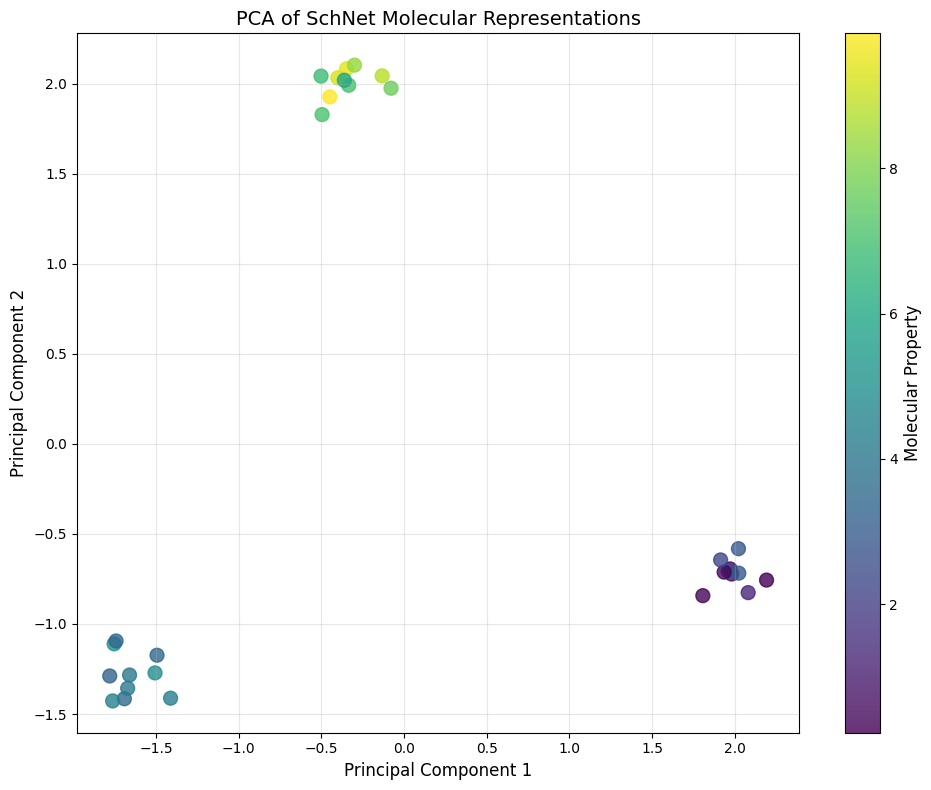

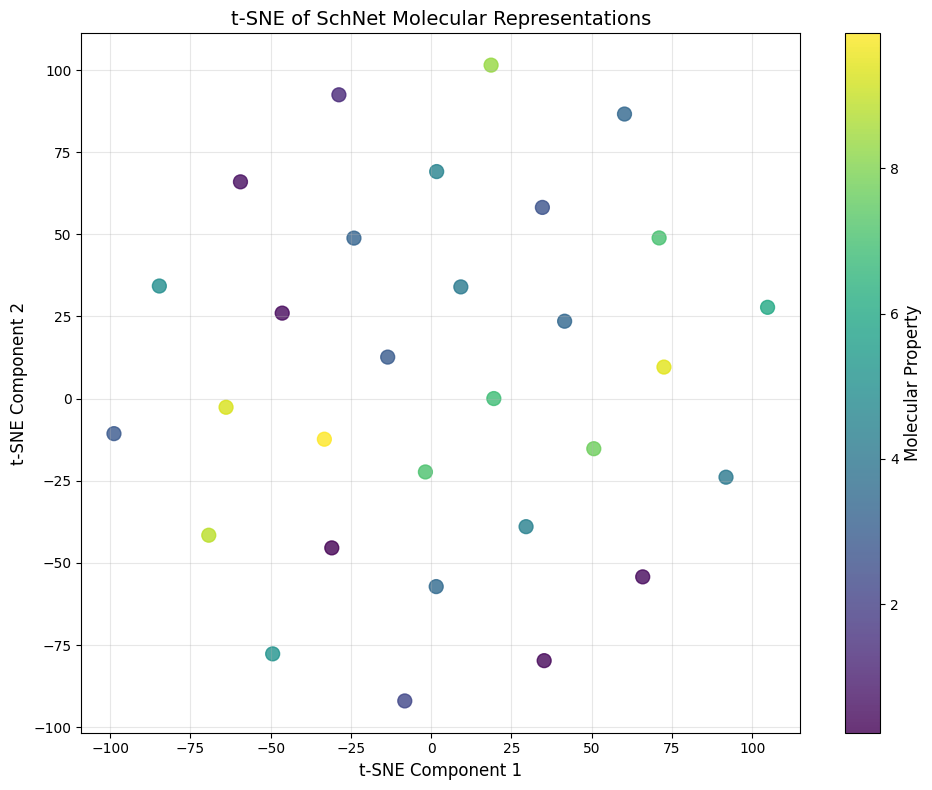

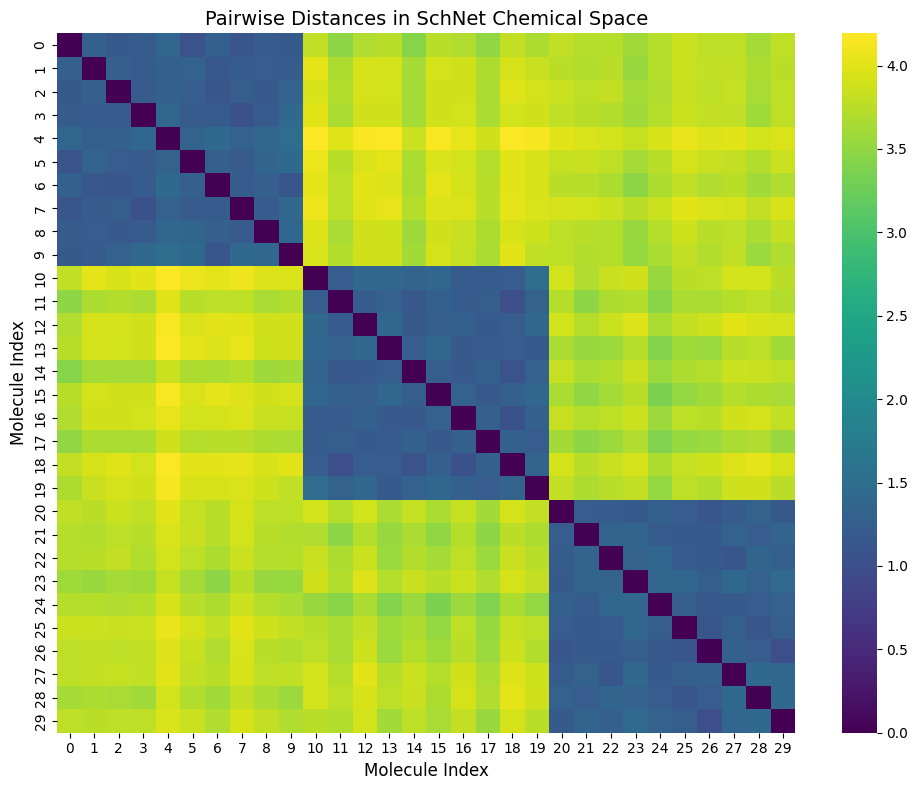

In [17]:
def visualize_molecular_representations():
    """
    Visualize learned molecular representations from a SchNet model
    """
    try:
        # Try to extract features from the trained model and test loader
        if model is not None and test_loader is not None:
            # Get a batch of molecules
            batch = next(iter(test_loader))
            batch = {k: v.to('cpu') for k, v in batch.items()}

            # Get molecular features (before the output layer)
            model.eval()
            with torch.no_grad():
                # Extract the features before the output layer
                # This is model-specific and depends on the SchNet implementation
                if hasattr(model, 'representation'):
                    # Get features from representation
                    features = model.representation(batch)

                    # If features is not atom-wise, but molecule-wise, we can use it directly
                    if not hasattr(features, 'shape') or features.shape[0] == batch['_idx'].shape[0]:
                        mol_features = features
                    else:
                        # Otherwise, we need to aggregate atom-wise features
                        mol_features = spk.atomistic.Atomwise(
                            n_in=features.shape[-1],
                            aggregation_mode='mean'
                        )(features, batch)

                    # Convert to numpy
                    mol_features = mol_features.detach().cpu().numpy()
                    print(f"Extracted features of shape {mol_features.shape}")
                else:
                    raise AttributeError("Cannot extract features from model")
        else:
            raise AttributeError("Model or test loader not available")

    except (AttributeError, NameError):
        # Create mock features for visualization
        print("Using mock molecular features for visualization")

        # Create mock features for a small set of molecules
        n_molecules = 30
        feature_dim = 64

        # Generate random features
        mol_features = np.random.randn(n_molecules, feature_dim) * 0.1

        # Create a simple chemical space
        # Molecules with different properties (size, polarity, etc.)
        # We'll create three clusters representing different molecule types

        # Cluster 1: Small non-polar (e.g., alkanes)
        mol_features[:10, :10] += 0.8

        # Cluster 2: Medium-sized polar (e.g., alcohols, amines)
        mol_features[10:20, 10:20] += 0.8

        # Cluster 3: Large, aromatic (e.g., aromatics, heterocycles)
        mol_features[20:, 20:30] += 0.8

        # Add some random noise
        mol_features += np.random.randn(*mol_features.shape) * 0.05

    # Apply dimensionality reduction for visualization
    if mol_features.shape[1] > 2:
        # Use PCA for dimensionality reduction
        pca = PCA(n_components=2)
        mol_features_2d = pca.fit_transform(mol_features)

        # Also try t-SNE for comparison
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(mol_features) - 1))
        mol_features_tsne = tsne.fit_transform(mol_features)
    else:
        mol_features_2d = mol_features
        mol_features_tsne = mol_features

    # Create mock molecular property values for coloring
    # We'll create a property that correlates with the clusters
    mol_property = np.zeros(len(mol_features))

    # Assign property values based on features or clusters
    for i in range(len(mol_features)):
        if i < 10:
            # Cluster 1: Low values
            mol_property[i] = np.random.uniform(0.0, 3.0)
        elif i < 20:
            # Cluster 2: Medium values
            mol_property[i] = np.random.uniform(3.0, 6.0)
        else:
            # Cluster 3: High values
            mol_property[i] = np.random.uniform(6.0, 10.0)

    # Visualize PCA embeddings
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        mol_features_2d[:, 0],
        mol_features_2d[:, 1],
        c=mol_property,
        cmap='viridis',
        s=100,
        alpha=0.8
    )

    # Add a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Molecular Property', fontsize=12)

    # Add axis labels and title
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.title('PCA of SchNet Molecular Representations', fontsize=14)

    # Add a grid
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualize t-SNE embeddings
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        mol_features_tsne[:, 0],
        mol_features_tsne[:, 1],
        c=mol_property,
        cmap='viridis',
        s=100,
        alpha=0.8
    )

    # Add a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Molecular Property', fontsize=12)

    # Add axis labels and title
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('t-SNE of SchNet Molecular Representations', fontsize=14)

    # Add a grid
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create a more interactive plot with Plotly
    fig = px.scatter(
        x=mol_features_tsne[:, 0],
        y=mol_features_tsne[:, 1],
        color=mol_property,
        color_continuous_scale='Viridis',
        title="Interactive Visualization of SchNet Molecular Representations",
        labels={'color': 'Molecular Property'}
    )

    fig.update_traces(marker=dict(size=15, line=dict(width=2, color='DarkSlateGrey')))
    fig.update_layout(coloraxis_colorbar=dict(title="Molecular Property"))
    fig.show()

    # Create a heatmap of pairwise distances in the embedding space
    # This helps visualize the structure of the learned chemical space
    dist_matrix = np.zeros((len(mol_features), len(mol_features)))

    for i in range(len(mol_features)):
        for j in range(len(mol_features)):
            dist_matrix[i, j] = np.sqrt(np.sum((mol_features[i] - mol_features[j])**2))

    plt.figure(figsize=(10, 8))
    sns.heatmap(dist_matrix, cmap='viridis')
    plt.xlabel('Molecule Index', fontsize=12)
    plt.ylabel('Molecule Index', fontsize=12)
    plt.title('Pairwise Distances in SchNet Chemical Space', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize molecular representations
visualize_molecular_representations()

### Visualizing Local Chemical Potentials

SchNet enables the interpretation of predictions through "local chemical potentials" - a visualization technique showing how atoms contribute to molecular properties. Let's visualize these for a few molecules:

<ipython-input-19-1d6490dfe4fd>:104: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



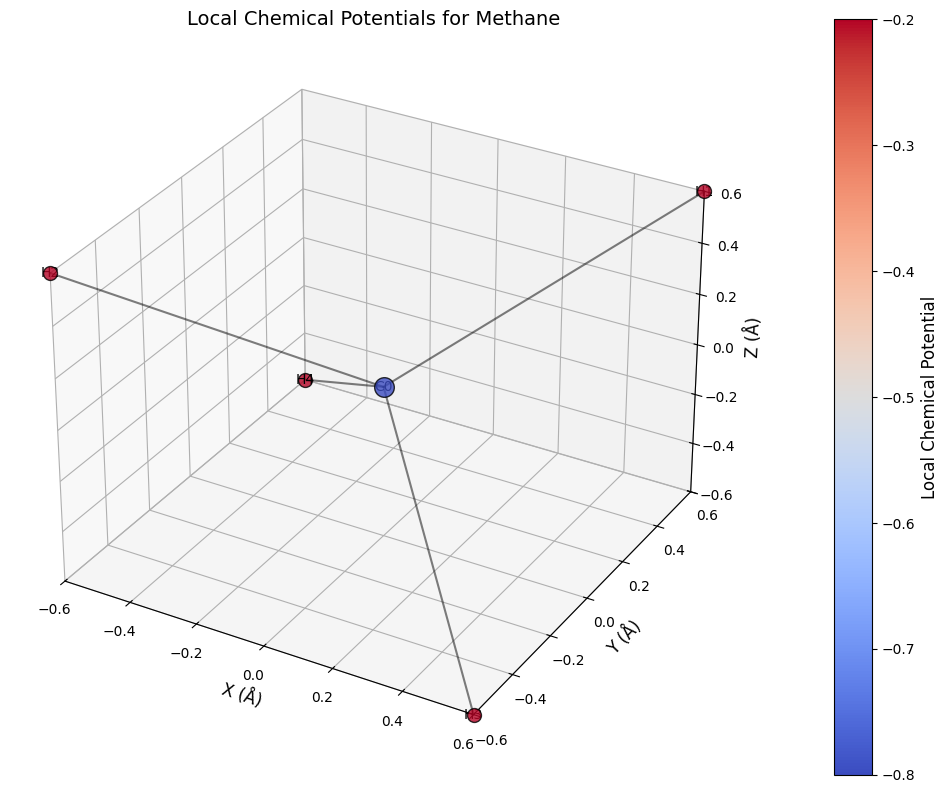

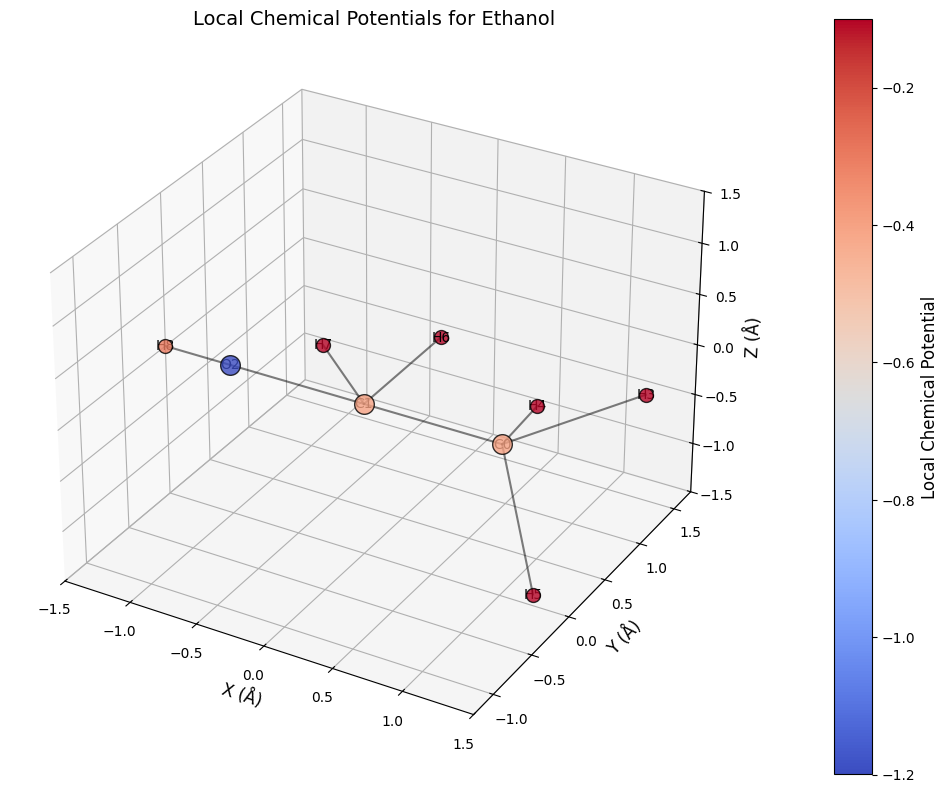

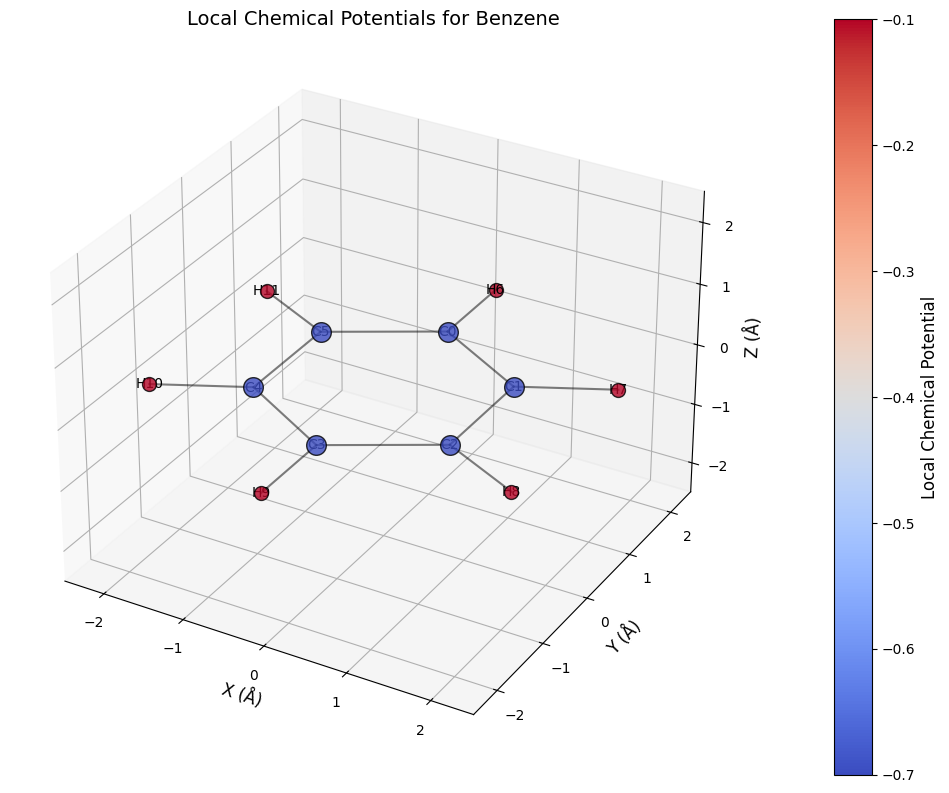

In [19]:
def visualize_local_chemical_potentials():
    """
    Visualize local chemical potentials derived from SchNet
    """
    # Since we need RDKit and a proper SchNet model for this,
    # we'll focus on visualization concepts with mock data

    # Create some simple molecules for visualization
    molecules = []

    # Methane
    molecules.append({
        'smiles': 'C',
        'name': 'Methane',
        'atoms': ['C', 'H', 'H', 'H', 'H'],
        'positions': np.array([
            [0.0, 0.0, 0.0],     # C
            [0.6, 0.6, 0.6],     # H
            [-0.6, -0.6, 0.6],   # H
            [0.6, -0.6, -0.6],   # H
            [-0.6, 0.6, -0.6],   # H
        ]),
        'local_energy': np.array([-0.8, -0.2, -0.2, -0.2, -0.2])  # Mock energy contributions
    })

    # Ethanol
    molecules.append({
        'smiles': 'CCO',
        'name': 'Ethanol',
        'atoms': ['C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H'],
        'positions': np.array([
            [1.0, 0.0, 0.0],    # C
            [0.0, 0.0, 0.0],    # C
            [-1.0, 0.0, 0.0],   # O
            [1.5, 1.0, 0.0],    # H
            [1.5, -0.5, 0.9],   # H
            [1.5, -0.5, -0.9],  # H
            [0.0, 1.0, 0.0],    # H
            [0.0, -0.5, 0.9],   # H
            [-1.5, 0.0, 0.0],   # H
        ]),
        'local_energy': np.array([-0.4, -0.4, -1.2, -0.1, -0.1, -0.1, -0.1, -0.1, -0.3])  # Mock energy
    })

    # Benzene
    molecules.append({
        'smiles': 'c1ccccc1',
        'name': 'Benzene',
        'atoms': ['C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'],
        'positions': np.array([
            [0.0, 1.4, 0.0],      # C
            [1.2, 0.7, 0.0],      # C
            [1.2, -0.7, 0.0],     # C
            [0.0, -1.4, 0.0],     # C
            [-1.2, -0.7, 0.0],    # C
            [-1.2, 0.7, 0.0],     # C
            [0.0, 2.5, 0.0],      # H
            [2.2, 1.2, 0.0],      # H
            [2.2, -1.2, 0.0],     # H
            [0.0, -2.5, 0.0],     # H
            [-2.2, -1.2, 0.0],    # H
            [-2.2, 1.2, 0.0],     # H
        ]),
        'local_energy': np.array([-0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1])  # Mock energy
    })

    # Create visualizations
    for molecule in molecules:
        # Create a figure with 3D plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Get positions, atoms, and local energies
        positions = molecule['positions']
        atoms = molecule['atoms']
        local_energy = molecule['local_energy']

        # Define atom colors
        atom_colors = {
            'H': 'white',
            'C': 'black',
            'O': 'red',
            'N': 'blue',
            'F': 'green',
            'Cl': 'green',
            'Br': 'brown',
            'I': 'purple'
        }

        # Define atom sizes
        atom_sizes = {
            'H': 100,
            'C': 200,
            'O': 200,
            'N': 200,
            'F': 180,
            'Cl': 220,
            'Br': 240,
            'I': 260
        }

        # Create a colormap for the local energies
        norm = plt.Normalize(min(local_energy), max(local_energy))
        cmap = plt.cm.get_cmap('coolwarm')

        # Plot atoms
        for i, (pos, atom, energy) in enumerate(zip(positions, atoms, local_energy)):
            # Edge color is black, face color is atom color with opacity based on energy
            edge_color = 'black'
            face_color = cmap(norm(energy))

            # Plot the atom
            ax.scatter(pos[0], pos[1], pos[2], s=atom_sizes.get(atom, 150),
                      c=[face_color], edgecolor=edge_color, alpha=0.8)

            # Add text label
            ax.text(pos[0], pos[1], pos[2], f"{atom}{i}", fontsize=10, ha='center', va='center')

        # Draw bonds
        if molecule['name'] == 'Methane':
            # Connect all H atoms to C
            c_pos = positions[0]
            for i in range(1, 5):
                h_pos = positions[i]
                ax.plot([c_pos[0], h_pos[0]], [c_pos[1], h_pos[1]], [c_pos[2], h_pos[2]], 'k-', alpha=0.5)

        elif molecule['name'] == 'Ethanol':
            # C-C bond
            ax.plot([positions[0][0], positions[1][0]],
                    [positions[0][1], positions[1][1]],
                    [positions[0][2], positions[1][2]], 'k-', alpha=0.5)

            # C-O bond
            ax.plot([positions[1][0], positions[2][0]],
                    [positions[1][1], positions[2][1]],
                    [positions[1][2], positions[2][2]], 'k-', alpha=0.5)

            # C-H bonds for first C
            for i in range(3, 6):
                ax.plot([positions[0][0], positions[i][0]],
                        [positions[0][1], positions[i][1]],
                        [positions[0][2], positions[i][2]], 'k-', alpha=0.5)

            # C-H bonds for second C
            for i in range(6, 8):
                ax.plot([positions[1][0], positions[i][0]],
                        [positions[1][1], positions[i][1]],
                        [positions[1][2], positions[i][2]], 'k-', alpha=0.5)

            # O-H bond
            ax.plot([positions[2][0], positions[8][0]],
                    [positions[2][1], positions[8][1]],
                    [positions[2][2], positions[8][2]], 'k-', alpha=0.5)

        elif molecule['name'] == 'Benzene':
            # Draw the hexagon (C-C bonds)
            for i in range(6):
                j = (i + 1) % 6
                ax.plot([positions[i][0], positions[j][0]],
                        [positions[i][1], positions[j][1]],
                        [positions[i][2], positions[j][2]], 'k-', alpha=0.5)

            # Draw C-H bonds
            for i in range(6):
                ax.plot([positions[i][0], positions[i+6][0]],
                        [positions[i][1], positions[i+6][1]],
                        [positions[i][2], positions[i+6][2]], 'k-', alpha=0.5)

        # Add a colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, pad=0.1)
        cbar.set_label('Local Chemical Potential', fontsize=12)

        # Set axis labels and title
        ax.set_xlabel('X (Å)', fontsize=12)
        ax.set_ylabel('Y (Å)', fontsize=12)
        ax.set_zlabel('Z (Å)', fontsize=12)
        ax.set_title(f'Local Chemical Potentials for {molecule["name"]}', fontsize=14)

        # Set equal aspect ratio
        max_range = np.array([
            positions[:, 0].max() - positions[:, 0].min(),
            positions[:, 1].max() - positions[:, 1].min(),
            positions[:, 2].max() - positions[:, 2].min()
        ]).max() / 2.0

        mid_x = (positions[:, 0].max() + positions[:, 0].min()) * 0.5
        mid_y = (positions[:, 1].max() + positions[:, 1].min()) * 0.5
        mid_z = (positions[:, 2].max() + positions[:, 2].min()) * 0.5

        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        plt.tight_layout()
        plt.show()

        # Create an interactive 3D visualization using Plotly
        fig = go.Figure()

        # Add atoms as spheres
        for i, (pos, atom, energy) in enumerate(zip(positions, atoms, local_energy)):
            # Get color from colormap
            color = 'rgb' + str(tuple(int(c*255) for c in cmap(norm(energy))[0:3]))

            # Add atom
            fig.add_trace(go.Scatter3d(
                x=[pos[0]],
                y=[pos[1]],
                z=[pos[2]],
                mode='markers',
                marker=dict(
                    size=atom_sizes.get(atom, 150) / 10,
                    color=color,
                    line=dict(width=2, color='black')
                ),
                text=f"{atom}{i}: {energy:.2f}",
                name=f"{atom}{i}"
            ))

        # Add bonds
        if molecule['name'] == 'Methane':
            c_pos = positions[0]
            for i in range(1, 5):
                h_pos = positions[i]
                fig.add_trace(go.Scatter3d(
                    x=[c_pos[0], h_pos[0]],
                    y=[c_pos[1], h_pos[1]],
                    z=[c_pos[2], h_pos[2]],
                    mode='lines',
                    line=dict(color='black', width=3),
                    showlegend=False
                ))

        elif molecule['name'] == 'Ethanol':
            # Add C-C and C-O bonds
            bond_indices = [(0, 1), (1, 2)]
            for i, j in bond_indices:
                fig.add_trace(go.Scatter3d(
                    x=[positions[i][0], positions[j][0]],
                    y=[positions[i][1], positions[j][1]],
                    z=[positions[i][2], positions[j][2]],
                    mode='lines',
                    line=dict(color='black', width=3),
                    showlegend=False
                ))

            # Add C-H and O-H bonds
            ch_indices = [(0, 3), (0, 4), (0, 5), (1, 6), (1, 7), (2, 8)]
            for i, j in ch_indices:
                fig.add_trace(go.Scatter3d(
                    x=[positions[i][0], positions[j][0]],
                    y=[positions[i][1], positions[j][1]],
                    z=[positions[i][2], positions[j][2]],
                    mode='lines',
                    line=dict(color='black', width=3),
                    showlegend=False
                ))

        elif molecule['name'] == 'Benzene':
            # Add C-C bonds (ring)
            for i in range(6):
                j = (i + 1) % 6
                fig.add_trace(go.Scatter3d(
                    x=[positions[i][0], positions[j][0]],
                    y=[positions[i][1], positions[j][1]],
                    z=[positions[i][2], positions[j][2]],
                    mode='lines',
                    line=dict(color='black', width=3),
                    showlegend=False
                ))

            # Add C-H bonds
            for i in range(6):
                fig.add_trace(go.Scatter3d(
                    x=[positions[i][0], positions[i+6][0]],
                    y=[positions[i][1], positions[i+6][1]],
                    z=[positions[i][2], positions[i+6][2]],
                    mode='lines',
                    line=dict(color='black', width=3),
                    showlegend=False
                ))

        # Update layout
        fig.update_layout(
            title=f'Interactive Local Chemical Potentials for {molecule["name"]}',
            scene=dict(
                xaxis_title='X (Å)',
                yaxis_title='Y (Å)',
                zaxis_title='Z (Å)'
            )
        )
        fig.show()

visualize_local_chemical_potentials()

## 7. Applications and Future Directions <a name="applications"></a>

SchNet has demonstrated impressive success in a variety of quantum chemistry and materials science applications. In this section, we'll explore some of the key applications and future directions for 3D-aware neural networks like SchNet.

### Current Applications

#### 1. Quantum Chemistry

SchNet has been particularly successful in predicting quantum-mechanical properties:

- **Molecular Energies**: Prediction of ground state energies and formation energies
- **Force Fields**: Learning accurate interatomic forces for molecular dynamics simulations
- **Electron Densities**: Mapping the electron density distribution within molecules
- **HOMO-LUMO Gaps**: Predicting electronic properties relevant for optoelectronic applications

#### 2. Materials Science

Beyond molecules, SchNet has been applied to materials science problems:

- **Crystal Properties**: Predicting properties of crystalline materials
- **Phase Transitions**: Understanding phase changes in materials
- **Defect Energetics**: Modeling defects in crystal structures
- **Surface Chemistry**: Studying surface reactions and catalysis

#### 3. Drug Discovery

SchNet's ability to model 3D molecular structures makes it valuable for pharmaceutical applications:

- **Binding Affinity Prediction**: Estimating how strongly a molecule will bind to a target protein
- **Drug Property Prediction**: ADMET (Absorption, Distribution, Metabolism, Excretion, Toxicity) predictions
- **Molecular Generation**: Generating molecules with desired properties (when combined with generative models)

### Advantages of SchNet Over Traditional Approaches

Let's compare SchNet with traditional methods in computational chemistry:

In [20]:
# Create a comparison table of SchNet vs traditional methods
comparison_data = {
    'Method': ['Traditional Force Fields', 'Density Functional Theory (DFT)', 'SchNet'],
    'Accuracy': ['Moderate (relies on parameterization)', 'High (first principles)', 'High (learns from DFT data)'],
    'Computational Cost': ['Low (seconds to minutes)', 'High (hours to days)', 'Low after training (milliseconds)'],
    'Transferability': ['Limited to parameterized systems', 'Universal but expensive', 'Good within chemical space of training data'],
    'Scale': ['Millions of atoms', 'Hundreds of atoms', 'Thousands of atoms'],
    '3D Awareness': ['Yes (explicit modeling)', 'Yes (quantum mechanical)', 'Yes (learned representation)'],
    'Chemical Flexibility': ['Limited by force field type', 'Universal', 'Depends on training data diversity']
}

# Create a DataFrame for visualization
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)

# Display the table
comparison_df.style.hide(axis='index')

Method,Accuracy,Computational Cost,Transferability,Scale,3D Awareness,Chemical Flexibility
Traditional Force Fields,Moderate (relies on parameterization),Low (seconds to minutes),Limited to parameterized systems,Millions of atoms,Yes (explicit modeling),Limited by force field type
Density Functional Theory (DFT),High (first principles),High (hours to days),Universal but expensive,Hundreds of atoms,Yes (quantum mechanical),Universal
SchNet,High (learns from DFT data),Low after training (milliseconds),Good within chemical space of training data,Thousands of atoms,Yes (learned representation),Depends on training data diversity


### Future Directions and Challenges

While SchNet has made significant advances, several challenges and opportunities remain for 3D-aware molecular neural networks:

#### 1. Enhanced Architectures

**Current Developments:**

- **DimeNet**: Adds directional information by incorporating angular features (bond angles)
- **GemNet**: Further extends to include 3-body and 4-body interactions
- **Equivariant Networks**: SO(3)-equivariant models that respect rotational symmetry by design
- **Transformers for Molecules**: Applying attention mechanisms to molecular modeling

#### 2. Data Efficiency

- **Active Learning**: Strategically selecting which molecules to compute DFT data for
- **Transfer Learning**: Leveraging models trained on similar tasks or datasets
- **Semi-supervised Approaches**: Combining labeled and unlabeled data
- **Multi-fidelity Learning**: Combining data from different levels of theory

#### 3. Broader Applications

- **Reaction Prediction**: Modeling chemical reactions and transition states
- **Excited States**: Going beyond ground state properties to excited state modeling
- **Multi-scale Modeling**: Bridging quantum, molecular, and mesoscale modeling
- **Non-equilibrium Dynamics**: Modeling systems away from equilibrium

#### 4. Interpretability and Explainability

- **Attribution Methods**: Understanding which parts of a molecule contribute to predictions
- **Feature Importance**: Identifying which 3D features drive molecular properties
- **Uncertainty Quantification**: Providing confidence estimates with predictions
- **Physics-informed Models**: Incorporating known physical laws into neural architectures

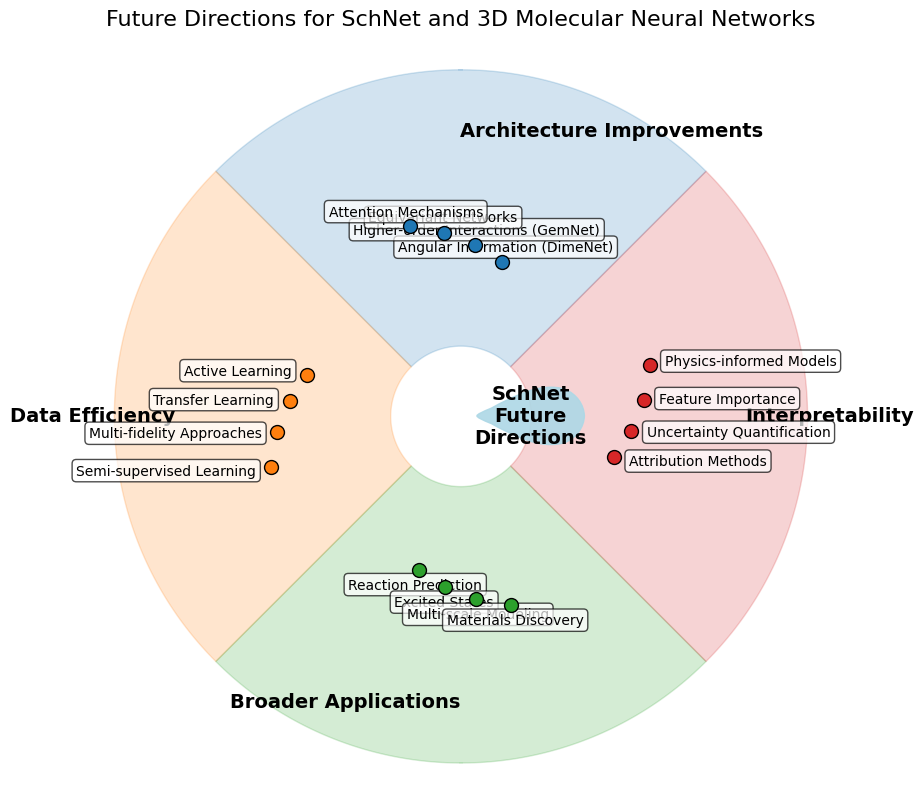

In [21]:
# Create a visualization of future directions for SchNet
def plot_future_directions():
    # Create a figure
    plt.figure(figsize=(12, 8))

    # Define main areas and specific directions
    areas = [
        'Architecture Improvements',
        'Data Efficiency',
        'Broader Applications',
        'Interpretability'
    ]

    specific_directions = {
        'Architecture Improvements': [
            'Angular Information (DimeNet)',
            'Higher-order Interactions (GemNet)',
            'Equivariant Networks',
            'Attention Mechanisms'
        ],
        'Data Efficiency': [
            'Active Learning',
            'Transfer Learning',
            'Multi-fidelity Approaches',
            'Semi-supervised Learning'
        ],
        'Broader Applications': [
            'Reaction Prediction',
            'Excited States',
            'Multi-scale Modeling',
            'Materials Discovery'
        ],
        'Interpretability': [
            'Attribution Methods',
            'Uncertainty Quantification',
            'Feature Importance',
            'Physics-informed Models'
        ]
    }

    # Calculate positions
    n_areas = len(areas)
    angles = np.linspace(0, 2*np.pi, n_areas, endpoint=False)

    # Adjust angles to start from the top
    angles = angles + np.pi/2

    # Plot the areas
    ax = plt.subplot(111, polar=True)

    # Plot the circular segments for main areas
    for i, area in enumerate(areas):
        start_angle = angles[i] - np.pi/n_areas
        end_angle = angles[i] + np.pi/n_areas

        # Create a colored segment
        theta = np.linspace(start_angle, end_angle, 100)
        radii = np.ones_like(theta) * 1.8

        # Plot the segment with transparency
        ax.fill_between(theta, 0, radii, alpha=0.2, color=f"C{i}")

        # Add the area label
        angle = angles[i]
        x = 1.4 * np.cos(angle)
        y = 1.4 * np.sin(angle)
        ha = 'center'
        if np.cos(angle) < 0:
            ha = 'right'
        elif np.cos(angle) > 0:
            ha = 'left'
        plt.text(angle, 1.4, area, ha=ha, va='center', fontsize=14, fontweight='bold')

        # Add specific directions
        for j, direction in enumerate(specific_directions[area]):
            # Calculate position
            inner_radius = 0.5
            radius = inner_radius + (0.9 - inner_radius) * ((j + 1) / (len(specific_directions[area]) + 1))

            # Adjust angle slightly for better spacing
            dir_angle = angle - np.pi/12 + (j * np.pi/6) / (len(specific_directions[area]) - 1)

            x = radius * np.cos(dir_angle)
            y = radius * np.sin(dir_angle)

            # Add a point
            ax.scatter(dir_angle, radius, s=100, color=f"C{i}", edgecolor='black', zorder=10)

            # Add the direction label
            text_radius = radius + 0.1
            ha = 'center'
            if np.cos(dir_angle) < -0.3:
                ha = 'right'
            elif np.cos(dir_angle) > 0.3:
                ha = 'left'
            plt.text(dir_angle, text_radius, direction, ha=ha, va='center', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

    # Add SchNet in the center
    circle = plt.Circle((0, 0), 0.35, color='lightblue', alpha=0.9)
    ax.add_patch(circle)
    plt.text(0, 0, 'SchNet\nFuture\nDirections', ha='center', va='center', fontsize=14, fontweight='bold')

    # Remove unnecessary elements
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid(False)

    plt.title('Future Directions for SchNet and 3D Molecular Neural Networks', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Visualize future directions
plot_future_directions()

## 8. Conclusion <a name="conclusion"></a>

In this tutorial, we've explored SchNet, a pioneering deep learning architecture for 3D molecular modeling. Let's summarize what we've learned:

### Key Takeaways

1. **3D Information is Critical**: Unlike traditional GNNs, SchNet incorporates 3D atomic coordinates, enabling more accurate predictions of quantum-mechanical properties.

2. **Continuous-Filter Convolutions**: SchNet uses continuous-filter convolutions to operate on arbitrary atom positions, generalizing CNNs to molecular data.

3. **Physics-Informed Design**: By respecting physical symmetries (rotational, translational, and permutation invariance), SchNet makes predictions that follow fundamental physical laws.

4. **End-to-End Learning**: SchNet learns directly from atomic positions and types, without requiring predefined molecular descriptors or fingerprints.

5. **Interpretability**: The model enables visualization of atomic contributions (local chemical potentials), providing insights into how different parts of a molecule contribute to its properties.

### Practical Implications

SchNet and similar 3D-aware neural networks have several practical implications for chemistry and materials science:

- **Accelerating Quantum Chemistry**: Predictions in milliseconds that would take hours or days with traditional DFT calculations
- **Exploring Chemical Space**: Efficiently screening millions of candidate molecules for desired properties
- **Accurate Force Fields**: Creating ML-based force fields that approach quantum accuracy at classical computational cost
- **Structure-Property Relationships**: Gaining new insights into how 3D structure influences molecular properties

### Getting Started with SchNet

If you're interested in applying SchNet to your own research, here are some resources to get started:

- **SchNetPack**: The official implementation of SchNet - https://github.com/atomistic-machine-learning/schnetpack
- **QM9 Dataset**: A standard benchmark dataset for molecular property prediction - https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904
- **PyTorch Geometric**: Offers implementations of various GNNs including SchNet - https://pytorch-geometric.readthedocs.io/

### Final Thoughts

SchNet represents an important paradigm shift in molecular modeling, demonstrating how deep learning can complement and potentially transform quantum chemistry. It bridges the gap between data-driven approaches and physical understanding, paving the way for more accurate, efficient, and insightful molecular modeling.

As the field continues to advance, we can expect 3D-aware neural networks to play an increasingly important role in drug discovery, materials design, and fundamental chemical research.